In [ ]:
# IMPORTS

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import networkx as nx
import pandas as pd
import seaborn as sns
import random
from scipy.integrate import solve_ivp
from scipy.stats import poisson

## **Question 1.1**

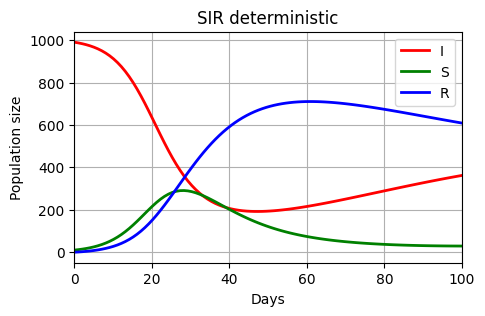

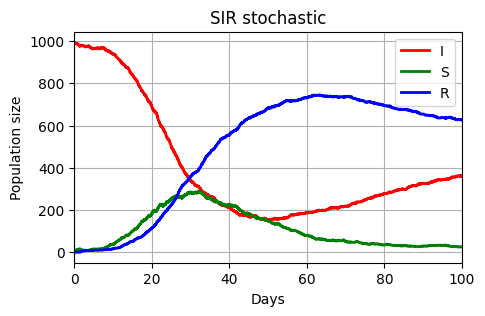

In [ ]:
# Question 1.1 (SIR, with demography)
"""
QUESTION: Write some python code to implement Gillespies Algorithm (GA)1
. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.
BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

References for gillespie explanation etc:

https://www.biosym.uzh.ch/modules/models/ETHZ/StochasticSimulation/sir_stoch.xhtml
"""

# Plot the results
def plot11(ts, Ss, Is, Rs, title):
  plt.figure(figsize=(5, 3))
  plt.plot(ts, Ss, 'r-', linewidth=2, label='I')
  plt.plot(ts, Is, 'g-', linewidth=2, label='S')
  plt.plot(ts, Rs, 'b-', linewidth=2, label='R')
  plt.xlabel('Days')
  plt.ylabel('Population size')
  plt.title(title)
  plt.xlim(0, 100)
  plt.legend()
  plt.grid(True)
  plt.show()


# implements the gillespie algorithm including a mu rate for the birth and
# death rate
def gillespie(S, I , R, beta, gamma, mu, max_time):
    t = 0
    output = []
    N_total = S + I + R

    while t < max_time:
        output.append([t, S, I, R])

        rate_infection = beta * S * I / N_total
        rate_recovery = gamma * I
        rate_birth = mu * N_total
        rate_death_S = mu * S
        rate_death_I = mu * I
        rate_death_R = mu * R

        total_rate = (rate_infection + rate_recovery + rate_birth +
                      rate_death_S + rate_death_I + rate_death_R)

        if total_rate == 0:
            break

        # Calculate the time step from an exponential distribution
        time_step = np.random.exponential(1 / total_rate)
        t += time_step

        rand = np.random.rand() * total_rate

        if rand < rate_infection:
            if S >= 1:
                S -= 1
                I += 1
        elif rand < rate_infection + rate_recovery:
            if I >= 1:
                I -= 1
                R += 1
        elif rand < rate_infection + rate_recovery + rate_birth:
            S += 1
            N_total += 1
        elif rand < rate_infection + rate_recovery + rate_birth + rate_death_S:
            if S >= 1:
                S -= 1
                N_total -= 1
        elif rand < (rate_infection + rate_recovery + rate_birth +
                     rate_death_S + rate_death_I):
            if I >= 1:
                I -= 1
                N_total -= 1
        else:
            if R >= 1:
                R -= 1
                N_total -= 1

    output.append([t, S, I, R])
    return np.array(output)


# implements the 'extended' SIR model with infection rate beta and recovery rate
# gamma and birht rate mu
def SIR_model(y, t, beta, gamma, mu):
    S, I, R = y
    dSdt = mu - (beta * S * I) - (mu * S)
    dIdt = (beta * S * I) - (gamma * I) - (mu * I)
    dRdt = (gamma * I) - (mu * R)
    return [dSdt, dIdt, dRdt]

# Initial conditions for SIR model
S0 = 0.99
I0 = 0.01
R0 = 0.0
initial_conditions = [S0, I0, R0]

# scale to Gillespie
GP_scale = 1000

# Time array for simulation
ts_ODE = np.linspace(0, 100, 100)

# Parameters for epidemic scenario (R0 > 1)
beta = 0.3
gamma = 0.1
mu = 0.01

# Solve the extended SIR model
results = odeint(SIR_model, initial_conditions, ts_ODE, args=(beta, gamma, mu))

# scale for comparison and extract the S, I and R sizes
results *= GP_scale

Ss_ODE = results[:, 0]
Is_ODE = results[:, 1]
Rs_ODE = results[:, 2]

# plot deterministic SIR
plot11(ts_ODE, Ss_ODE, Is_ODE, Rs_ODE, 'SIR deterministic')

# scale the initial values for GP
S0 *= GP_scale
I0 *= GP_scale
R0 *= GP_scale

# run the gillespie algorithm
max_time = 100

# run GP
results = gillespie(S0, I0, R0, beta, gamma, mu, max_time)

# extract S, I and R values
times = results[:, 0]
susceptibles = results[:, 1]
infecteds = results[:, 2]
recovereds = results[:, 3]

# plot the values
plot11(times, susceptibles, infecteds, recovereds, 'SIR stochastic')

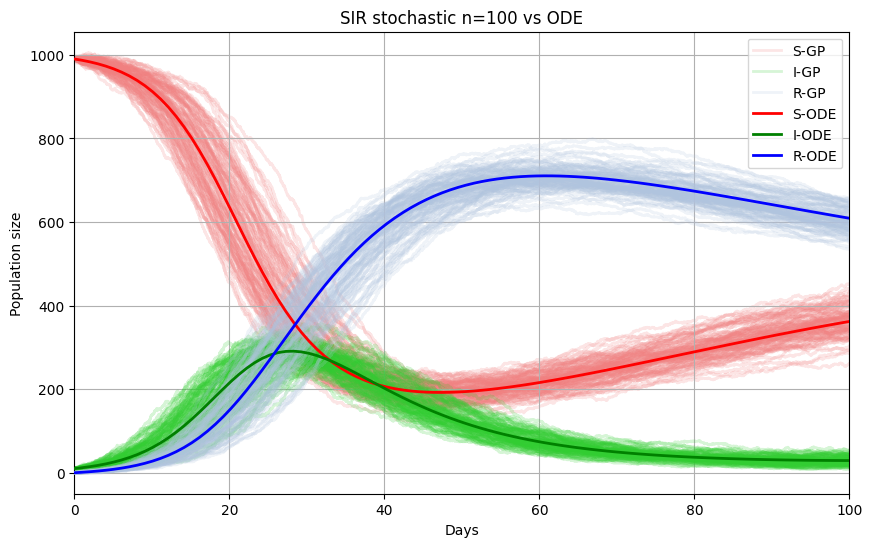

In [ ]:
# Question 1.1 (SIR, with demography) continued

def plot11_n(tss, Sss, Iss, Rss, title, ts, Ss, Is, Rs):
  plt.figure(figsize=(10, 6))

  # Plot each line without normalization
  for i in range(len(Sss)):
    plt.plot(tss[i], Sss[i], color='lightcoral', linewidth=2, alpha=0.2, label='S-GP' if i == 0 else "", zorder=1)
    plt.plot(tss[i], Iss[i], color='limegreen', linewidth=2, alpha=0.2, label='I-GP' if i == 0 else "", zorder=2)
    plt.plot(tss[i], Rss[i], color='lightsteelblue', linewidth=2, alpha=0.2, label='R-GP' if i == 0 else "", zorder=3)

  plt.plot(ts, Ss, 'r-', linewidth=2, label='S-ODE', zorder=3)
  plt.plot(ts, Is, 'g-', linewidth=2, label='I-ODE', zorder=3)
  plt.plot(ts, Rs, 'b-', linewidth=2, label='R-ODE', zorder=3)

  plt.xlabel('Days')
  plt.ylabel('Population size')
  plt.title(title)
  plt.xlim(0, 100)
  plt.grid(True)
  plt.legend()  # Add a legend to differentiate the lines
  plt.show()

def gillespie_standard_n(S, I, R, beta, gamma, mu, max_time, n):
  tss = []
  Sss = []
  Iss = []
  Rss = []
  for _ in range(n):
    output = gillespie(S, I, R, beta, gamma, mu, max_time)
    tss.append(output[:, 0])
    Sss.append(output[:, 1])
    Iss.append(output[:, 2])
    Rss.append(output[:, 3])
  return tss, Sss, Iss, Rss

n = 100
tss, Sss, Iss, Rss = gillespie_standard_n(S0, I0, R0, beta, gamma, mu, max_time, n)

plot11_n(tss, Sss, Iss, Rss, f'SIR stochastic n={n} vs ODE', ts_ODE, Ss_ODE, Is_ODE, Rs_ODE)


## **Question 1.2**

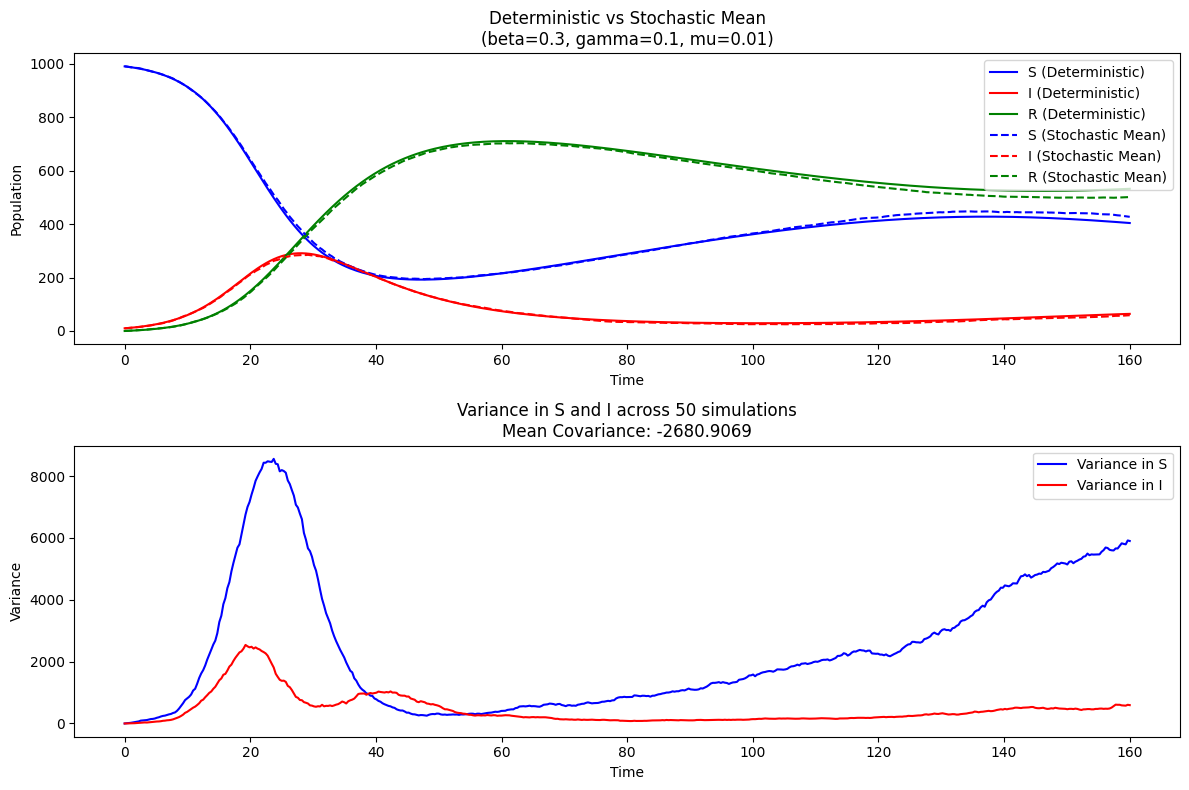

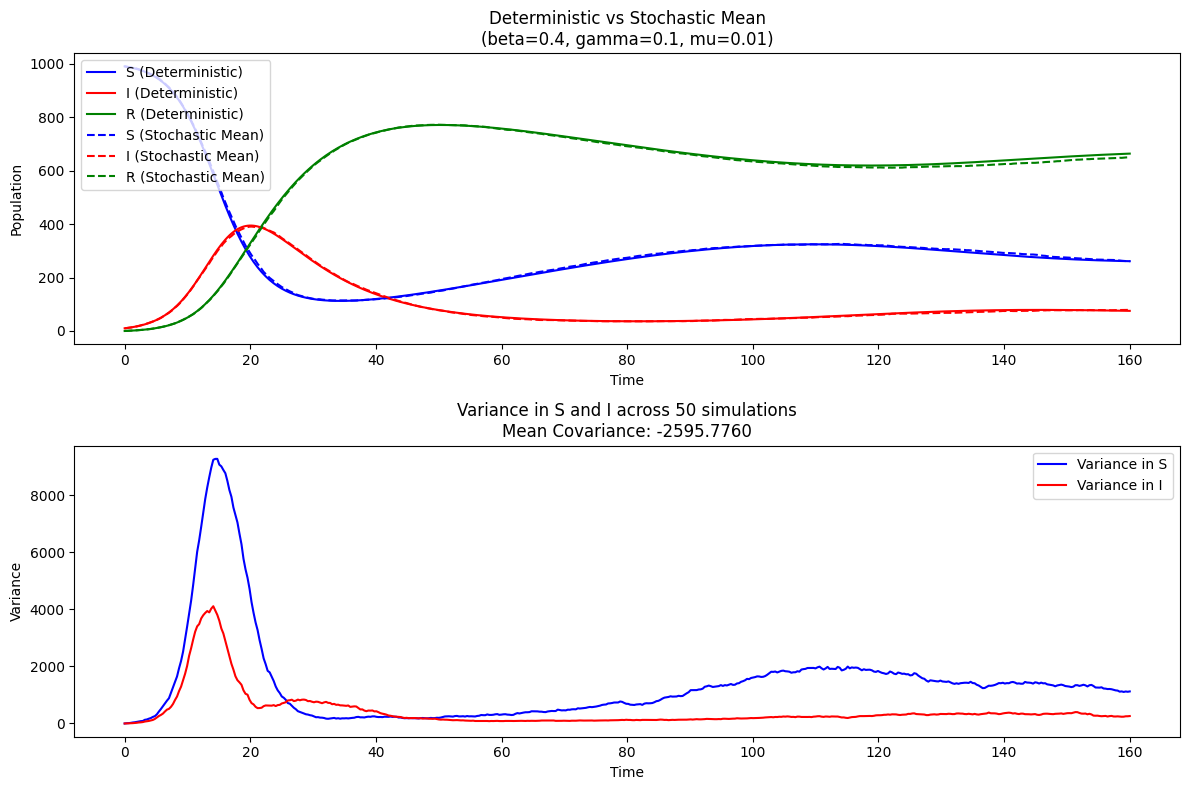

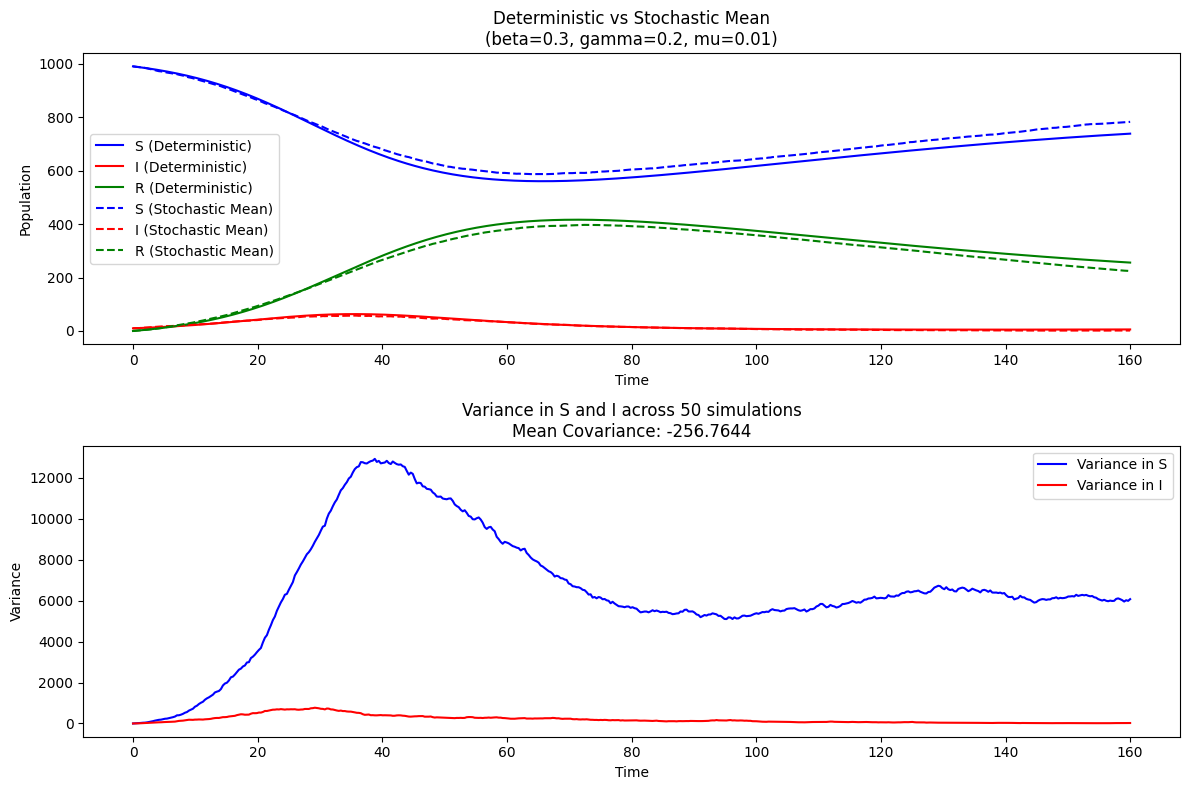

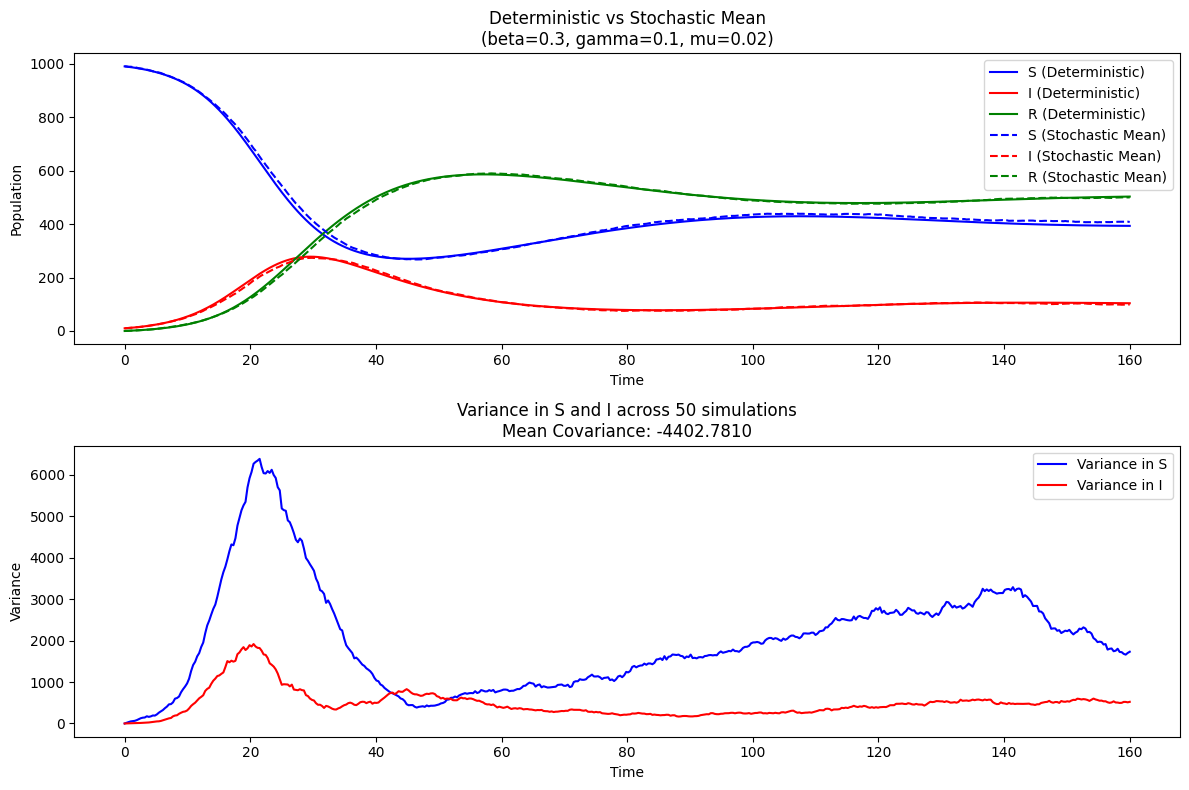

In [ ]:
# Question 1.2

"""
# QUESTION: (Investigate Simulation Variability and Negative Co-variance
# In the first experiment you should investigate how varying the model parameters changes
# the behaviour of the stochastic dynamics, in particular how they relate to variance between
# runs and how they impact negative covariance between S and I. Compare the mean of
# the stochastic simulations with the equivalent deterministic model output (do this for
# multiple settings of the model parameters).)
"""
# Parameters
scale_factor = 1000
S0_ODE, I0_ODE, R0_ODE = 0.99, 0.01, 0.0
S0_GP, I0_GP, R0_GP = S0_ODE * scale_factor, I0_ODE * scale_factor, R0_ODE * scale_factor
max_time = 160
num_simulations = 50

# Define different parameter sets to test
parameter_sets = [
    {'beta': 0.3, 'gamma': 0.1, 'mu': 0.01},
    {'beta': 0.4, 'gamma': 0.1, 'mu': 0.01},
    {'beta': 0.3, 'gamma': 0.2, 'mu': 0.01},
    {'beta': 0.3, 'gamma': 0.1, 'mu': 0.02},
]

# Time points for deterministic model
t = np.linspace(0, max_time, 500)

# Function to run simulations for a parameter set
def run_simulations(beta, gamma, mu):
    # Solve deterministic SIR model
    deterministic_solution = scale_factor * odeint(SIR_model, [S0_ODE, I0_ODE, R0_ODE], t, args=(beta, gamma, mu))

    # Run Gillespie simulations
    stochastic_solutions = []
    for _ in range(num_simulations):
        result = gillespie(S0_GP, I0_GP, R0_GP, beta, gamma, mu, max_time)
        stochastic_solutions.append(result)

    # Interpolate stochastic results for comparison with deterministic
    times = np.linspace(0, max_time, 500)
    stochastic_interp = np.zeros((len(times), 3))  # for mean S, I, R
    all_S, all_I = [], []

    for result in stochastic_solutions:
        interp_S = np.interp(times, result[:, 0], result[:, 1])
        interp_I = np.interp(times, result[:, 0], result[:, 2])
        interp_R = np.interp(times, result[:, 0], result[:, 3])
        stochastic_interp += np.vstack([interp_S, interp_I, interp_R]).T
        all_S.append(interp_S)
        all_I.append(interp_I)

    # Mean stochastic results
    mean_stochastic = stochastic_interp / num_simulations

    # Covariance between S and I for all simulations
    covariances = [np.cov(all_S[i], all_I[i])[0, 1] for i in range(num_simulations)]
    mean_covariance = np.mean(covariances)

    # Plot deterministic vs mean stochastic
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, deterministic_solution[:, 0], 'b', label='S (Deterministic)')
    plt.plot(t, deterministic_solution[:, 1], 'r', label='I (Deterministic)')
    plt.plot(t, deterministic_solution[:, 2], 'g', label='R (Deterministic)')
    plt.plot(times, mean_stochastic[:, 0], 'b--', label='S (Stochastic Mean)')
    plt.plot(times, mean_stochastic[:, 1], 'r--', label='I (Stochastic Mean)')
    plt.plot(times, mean_stochastic[:, 2], 'g--', label='R (Stochastic Mean)')
    plt.legend()
    plt.title(f'Deterministic vs Stochastic Mean\n(beta={beta}, gamma={gamma}, mu={mu})')
    plt.xlabel('Time')
    plt.ylabel('Population')

    # Plot variance across simulations
    plt.subplot(2, 1, 2)
    var_S = np.var(all_S, axis=0)
    var_I = np.var(all_I, axis=0)
    plt.plot(times, var_S, 'b', label='Variance in S')
    plt.plot(times, var_I, 'r', label='Variance in I')
    plt.legend()
    plt.title(f'Variance in S and I across {num_simulations} simulations\nMean Covariance: {mean_covariance:.4f}')
    plt.xlabel('Time')
    plt.ylabel('Variance')

    plt.tight_layout()
    plt.show()

# Run simulations for each parameter set
for params in parameter_sets:
    run_simulations(params['beta'], params['gamma'], params['mu'])


# **Question 1.3**


## **1.3.1**: stochastic resonance (general)

In [ ]:
"""
# Question 1.3
# (Stochastic Resonance and Increased Transients
# Show how the stochastic model can induce stochastic resonance around the equilibrium
# and how that resonance relates to the model parameters (e.g., N, β).
# Show some examples of increased transients away from the deterministic equilibrium
# - can you show which parameter values lead to the largest transients?)

# Question 1.3.1: Stochastic resonance 'around' the equilibrium
# Run 50 runs with the same parameters, determine the equilibrium value,
# and lastly compare to the deterministic model.
"""

# Parameters
scale_factor = 1000
S0_ODE, I0_ODE, R0_ODE = 0.99, 0.01, 0.0
S0_GP, I0_GP, R0_GP = S0_ODE * scale_factor, I0_ODE * scale_factor, R0_ODE * scale_factor
max_time = 200
num_simulations = 50
beta, gamma, mu = 0.2, 0.1, 0.01

# Time points for the deterministic model
t = np.linspace(0, max_time, 1000)

# Calculate the deterministic equilibrium values
S_eq = gamma / beta
I_eq = 0
R_eq = 1 - S_eq

# Solve the deterministic system using the SIR model
deterministic_solution = scale_factor * odeint(SIR_model, [S0_ODE, I0_ODE, R0_ODE], t, args=(beta, gamma, mu))

# Run the specified number of stochastic simulations
stochastic_solutions = []
for _ in range(num_simulations):
    result = gillespie(S0_GP, I0_GP, R0_GP, beta, gamma, mu, max_time)
    stochastic_solutions.append(result)

# Interpolate stochastic results for easier comparison with deterministic
times = np.linspace(0, max_time, 1000)
mean_stochastic = np.zeros((len(times), 3))

for result in stochastic_solutions:
    interp_S = np.interp(times, result[:, 0], result[:, 1])
    interp_I = np.interp(times, result[:, 0], result[:, 2])
    interp_R = np.interp(times, result[:, 0], result[:, 3])
    mean_stochastic += np.vstack([interp_S, interp_I, interp_R]).T

# Average the stochastic results across simulations
mean_stochastic /= num_simulations


## **Question** 1.3.2: How does the resonance relate to the parameters?

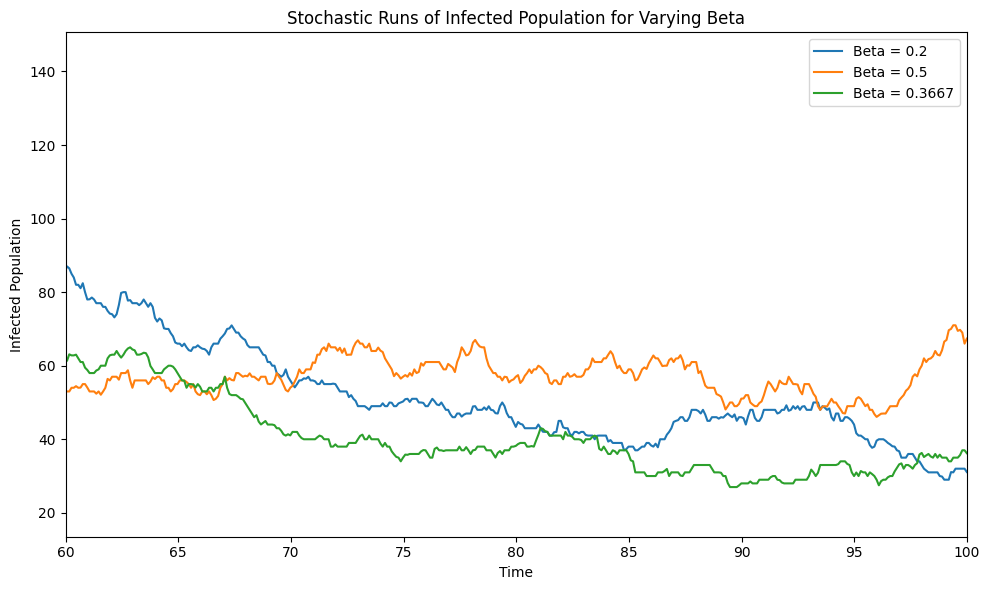

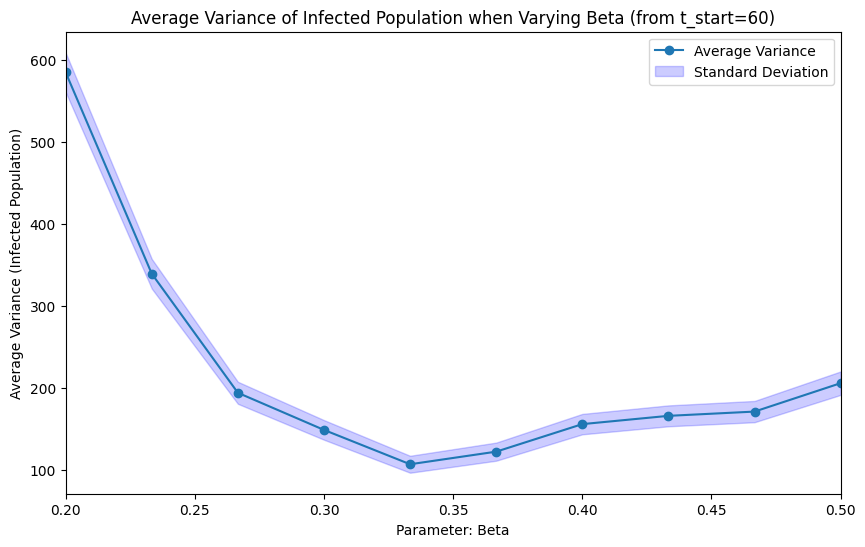

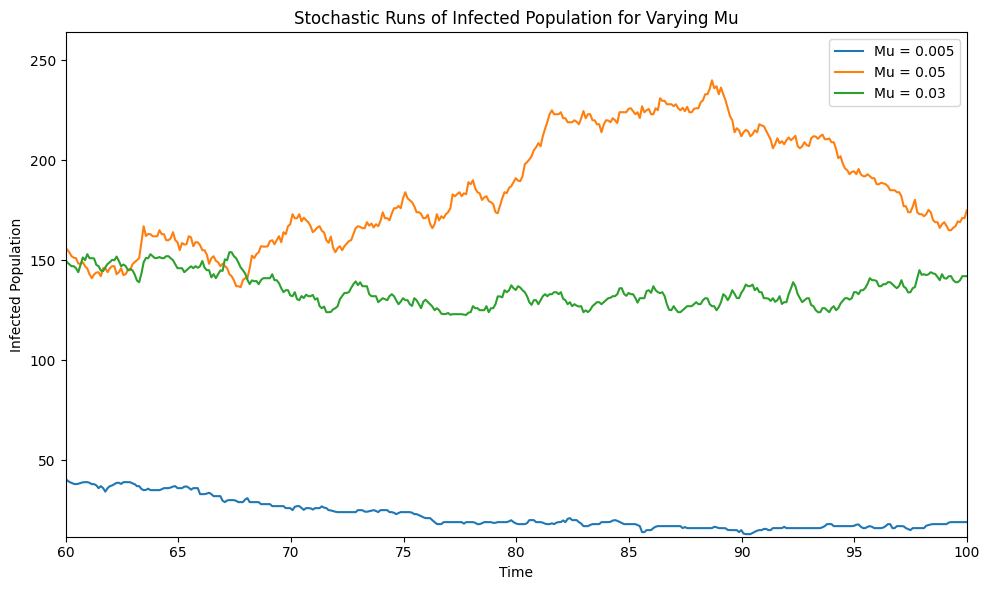

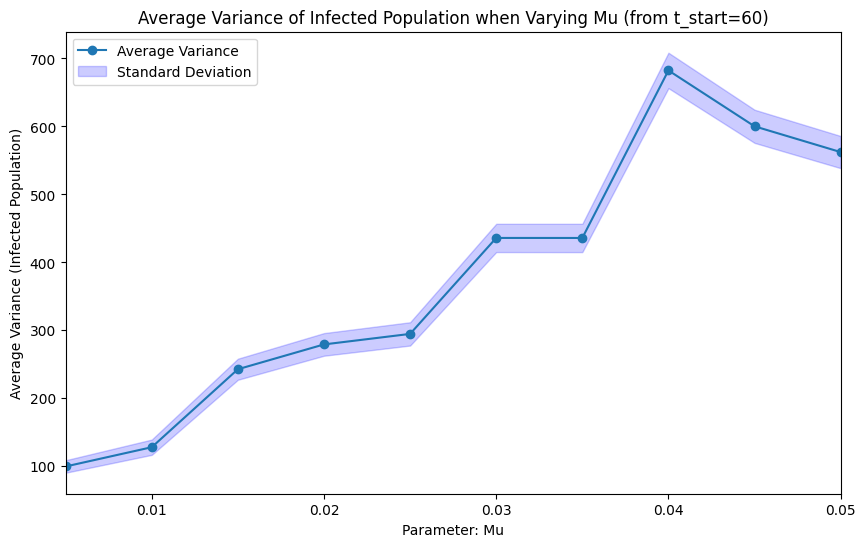

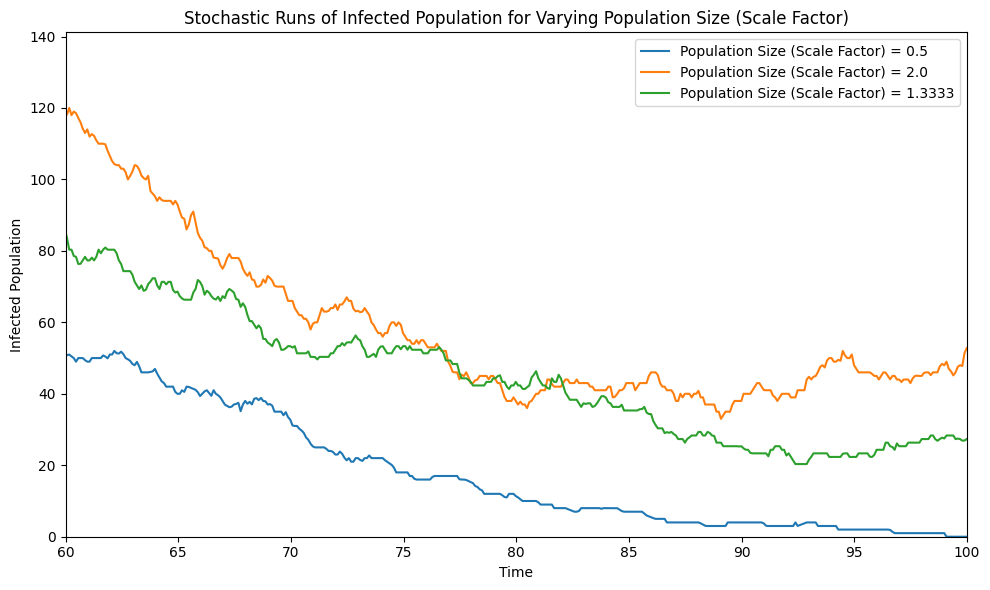

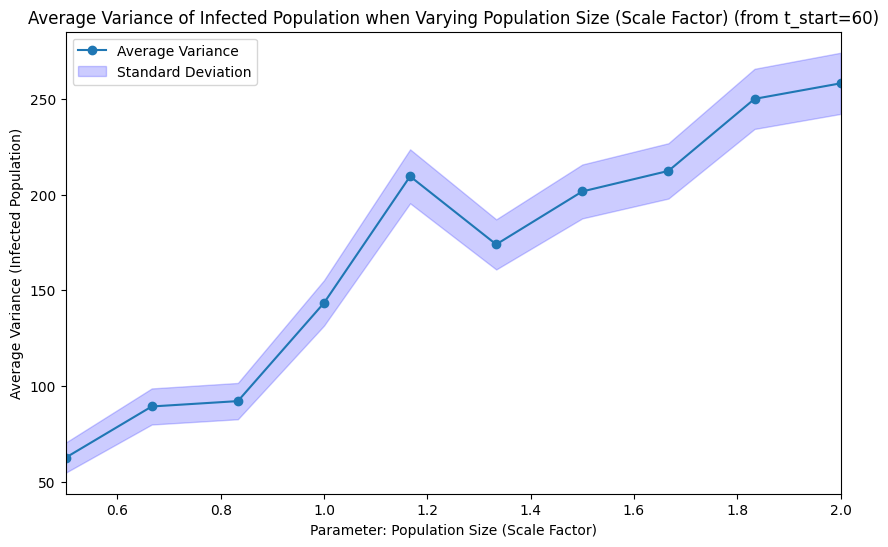

In [ ]:
# Parameters
scale_factor = 1000
S0_GP, I0_GP, R0_GP = 0.99 * scale_factor, 0.01 * scale_factor, 0.0
num_simulations = 60
times = np.linspace(0, max_time, 1000)

# Start time for calculations and plots
t_start = 60
# Create a mask to filter times from t_start onwards
time_mask = times >= t_start

# Standard parameter values
std_beta = 0.3
std_gamma = 0.1
std_mu = 0.01
std_N_scale = 1.0

# Define the varying values for each parameter
beta_vals = np.linspace(0.2, 0.5, 10)
mu_vals = np.linspace(0.005, 0.05, 10)
N_scales = np.linspace(0.5, 2.0, 10)


# Function to run simulations and calculate both variance and standard deviation
def run_simulation_vary_one_param(beta, gamma, mu, N_scale):
    S0, I0, R0 = S0_GP * N_scale, I0_GP * N_scale, R0_GP * N_scale
    stochastic_solutions = []

    for _ in range(num_simulations):
        result = gillespie(S0, I0, R0, beta, gamma, mu, max_time)
        stochastic_solutions.append(result)

    infected_runs = []

    for result in stochastic_solutions:
        interp_I = np.interp(times, result[:, 0], result[:, 2])
        infected_runs.append(interp_I)

    # Calculate variance and standard deviation of infected population across runs
    infected_runs = np.array(infected_runs)
    var_I = np.var(infected_runs, axis=0)
    std_I = np.std(infected_runs, axis=0)

    # Calculate average variance and std over time starting from t_start
    avg_variance = np.mean(var_I[time_mask])
    avg_std = np.mean(std_I[time_mask])

    return avg_variance, avg_std, stochastic_solutions


# Plot examples of stochastic runs
def plot_stochastic_examples(param_values, stochastic_solutions, times, param_name):
    plt.figure(figsize=(10, 6))

    # plot only the first last and middle runs of the stochastic stochastic_solutions
    i_s = [0, -1, len(stochastic_solutions) // 2]
    for i in i_s:
        result = stochastic_solutions[i]
        interp_I = np.interp(times, result[:, 0], result[:, 2])
        plt.plot(times, interp_I, label=f'{param_name} = {round(param_values[i], 4)}')

    plt.title(f'Stochastic Runs of Infected Population for Varying {param_name}')
    plt.xlabel('Time')
    plt.ylabel('Infected Population')
    plt.xlim(t_start, max_time)

    # Apply a mask to only consider the data from t_start onwards for y-axis limits
    time_mask = times >= t_start
    y_values = [np.interp(times[time_mask], result[:, 0], result[:, 2]) for result in stochastic_solutions]

    # Fit the y-axis limits to the values from t_start onwards
    plt.ylim([0.9 * min(y.min() for y in y_values), 1.1 * max(y.max() for y in y_values)])

    plt.legend()
    plt.tight_layout()
    plt.show()


# Function to plot average variance across varied parameters, with standard deviation
def plot_average_variances_with_std(parameter_vals, avg_variances, std_devs, param_name):
    plt.figure(figsize=(10, 6))

    # Convert to np for convenience
    avg_variances = np.array(avg_variances)
    std_devs = np.array(std_devs)

    # Plot average variance with error bands (standard deviation)
    plt.plot(parameter_vals, avg_variances, marker='o', label=f'Average Variance')
    plt.fill_between(parameter_vals,
                     avg_variances - std_devs,
                     avg_variances + std_devs,
                     color='b', alpha=0.2, label='Standard Deviation')

    plt.xlabel(f'Parameter: {param_name}')
    plt.ylabel('Average Variance (Infected Population)')
    plt.title(f'Average Variance of Infected Population when Varying {param_name} (from t_start={t_start})')
    plt.legend()
    plt.xlim(parameter_vals[0], parameter_vals[-1])  # Set x-axis limits
    plt.show()


# Vary parameters independently and plot results with standard deviation
def run_varying_parameters_with_std():
  # 1. Vary beta
  avg_variances_beta = []
  std_devs_beta = []
  test_sols = []
  for beta in beta_vals:
      avg_variance, avg_std, stochastic_solutions = run_simulation_vary_one_param(beta, std_gamma, std_mu, std_N_scale)
      avg_variances_beta.append(avg_variance)
      std_devs_beta.append(avg_std)

      # add only the first one of the 10 runs per parameter setting
      test_sols.append(stochastic_solutions[0])

  # Plot a few examples of the 10 runs
  plot_stochastic_examples(beta_vals, test_sols, times, 'Beta')
  plot_average_variances_with_std(beta_vals, avg_variances_beta, std_devs_beta, 'Beta')


  # 2. Vary mu
  avg_variances_mu = []
  std_devs_mu = []
  test_sols = []
  for mu in mu_vals:
      avg_variance, avg_std, stochastic_solutions = run_simulation_vary_one_param(std_beta, std_gamma, mu, std_N_scale)
      avg_variances_mu.append(avg_variance)
      std_devs_mu.append(avg_std)

      # add only the first one of the 10 runs per parameter setting
      test_sols.append(stochastic_solutions[0])

  # Plot a few examples of the 10 runs
  plot_stochastic_examples(mu_vals, test_sols, times, 'Mu')
  plot_average_variances_with_std(mu_vals, avg_variances_mu, std_devs_mu, 'Mu')


  # 3. Vary population size (N_scale)
  avg_variances_N = []
  std_devs_N = []
  test_sols = []
  for N_scale in N_scales:
      avg_variance, avg_std, stochastic_solutions = run_simulation_vary_one_param(std_beta, std_gamma, std_mu, N_scale)
      avg_variances_N.append(avg_variance)
      std_devs_N.append(avg_std)

      # add only the first one of the 10 runs per parameter setting
      test_sols.append(stochastic_solutions[0])

  # Plot a few examples of the 10 runs
  plot_stochastic_examples(N_scales, test_sols, times, 'Population Size (Scale Factor)')
  plot_average_variances_with_std(N_scales, avg_variances_N, std_devs_N, 'Population Size (Scale Factor)')

# Run the varying parameter simulations with std
run_varying_parameters_with_std()

## **Question 1.3.3**: which parameters lead to the largest transients

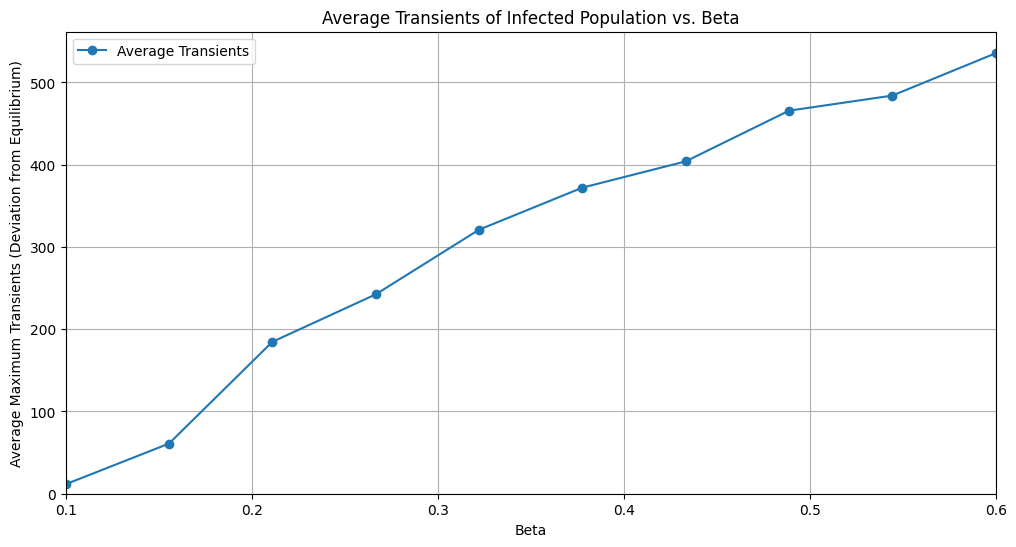

In [ ]:
"""
# beta has the most influence on the transients, so we will calculate the
# transients (from the equilibrium) and see how this varies across all the
# different values for beta.
"""

# Parameters
scale_factor = 1000
S0_GP, I0_GP, R0_GP = 0.99 * scale_factor, 0.01 * scale_factor, 0.0
max_time = 100
num_simulations = 10
times = np.linspace(0, max_time, 1000)

# Standard parameter values
std_gamma = 0.1
std_mu = 0.01

# Define the varying values for beta
beta_vals = np.linspace(0.1, 0.6, 10)

# Function to calculate equilibrium infected population with population constraints
def calculate_equilibrium(S0, beta, gamma):
    R0 = beta / gamma
    # Maximum infected at equilibrium cannot exceed total population minus susceptible
    max_infected = min(S0 * R0, scale_factor - S0)
    return max_infected

# Function to run simulations and calculate transients
def run_simulation_and_calculate_transients(beta, gamma):
    S0, I0, R0 = S0_GP, I0_GP, R0_GP
    transient_peaks = []

    for _ in range(num_simulations):
        result = gillespie(S0, I0, R0, beta, gamma, std_mu, max_time)

        # Calculate equilibrium value for the current beta
        equilibrium_I = calculate_equilibrium(S0_GP, beta, gamma)

        # Interpolate infected population over time
        interp_I = np.interp(times, result[:, 0], result[:, 2])

        # Calculate transient as deviation from equilibrium
        transients = np.abs(interp_I - equilibrium_I)

        # Store the maximum transient
        transient_peaks.append(np.max(transients))

    return np.mean(transient_peaks)

# Function to plot transients for different parameters
def plot_transients(beta_vals):
    avg_transients = []

    for beta in beta_vals:
        avg_transient = run_simulation_and_calculate_transients(beta, std_gamma)
        avg_transients.append(avg_transient)

    plt.figure(figsize=(12, 6))
    plt.plot(beta_vals, avg_transients, marker='o', label='Average Transients')

    plt.title('Average Transients of Infected Population vs. Beta')
    plt.xlabel('Beta')
    plt.ylabel('Average Maximum Transients (Deviation from Equilibrium)')
    plt.xlim(0.1, 0.6)
    plt.ylim(0, None)
    plt.grid()
    plt.legend()
    plt.show()

# Run the transient analysis
plot_transients(beta_vals)


# **Chapter** 1.4

In [ ]:
"""
In the lectures we have discussed the possibility of extinction of the virus even when
R0 > 1 in closed populations. Design an experiment to show how varying R0 impacts
the extinction process. Keep in mind that in the closed system randomness will always
eventually lead to extinction. Now look at how the extinction events are impacted by
the population size. Find a way to show how the two parameters R0 and N interact to
impact the extinction process.
"""

def sir_model_stochastic(t, y, beta, gamma, N):
    # SIR model differential equations for stochastic simulation
    S, I, R = y
    if I == 0:
        return [0, 0, 0]
    # Calculate infection and recovery rates
    infection_rate = beta * S * I / N
    recovery_rate = gamma * I
    # Determine new infections and recoveries using Poisson distribution
    new_infections = poisson.rvs(infection_rate) if infection_rate > 0 else 0
    new_recoveries = poisson.rvs(recovery_rate) if recovery_rate > 0 else 0
    # Update differential equations
    dSdt = -new_infections
    dIdt = new_infections - new_recoveries
    dRdt = new_recoveries
    return [dSdt, dIdt, dRdt]

def run_simulation(N, R0, gamma, t_max, initial_infected):
    # Run a single SIR stochastic simulation
    beta = R0 * gamma
    initial_conditions = [N - initial_infected, initial_infected, 0]
    # Solve the stochastic model using solve_ivp
    result = solve_ivp(sir_model_stochastic, [0, t_max], initial_conditions, args=(beta, gamma, N), t_eval=np.linspace(0, t_max, 1000))
    return result.t, result.y

def multiple_runs(N, R0, gamma, t_max, runs):
    # Run multiple simulations to estimate extinction probability
    extinction_counts = 0
    for _ in range(runs):
        t, y = run_simulation(N, R0, gamma, t_max, 1)
        if np.min(y[1]) == 0:  # Checking for extinction
            extinction_counts += 1
    return extinction_counts / runs

# Parameters for the experiment
population_sizes = np.logspace(3, 5, 10)  # From 1,000 to 100,000
R0_values = [0.8, 1.2, 1.6, 2.0]
gamma = 1/7
t_max = 365
runs = 50

# Calculate extinction probabilities for different R0 and population sizes
extinction_probabilities = {R0: [] for R0 in R0_values}

for N in population_sizes:
    for R0 in R0_values:
        prob = multiple_runs(int(N), R0, gamma, t_max, runs)
        extinction_probabilities[R0].append(prob)

# Plotting the results
plt.figure(figsize=(10, 6))
for R0 in R0_values:
    plt.plot(population_sizes, extinction_probabilities[R0], label=f'R0 = {R0}')
plt.xscale('log')
plt.xlabel('Population Size')
plt.ylabel('Probability of Extinction')
plt.title('Impact of R0 and Population Size on Virus Extinction Probability')
plt.legend()
plt.grid(True)
plt.show()


# **Chapter** 2.1

CSV Loaded:
      1467  1591  1513  1568  1562  1524  1771  1428  1600  1523  ...  1768  \
1467     0    17     0     0     0     0     0     0     0     0  ...     0   
1591    17     0     0     0     0     0     0     0     0     0  ...     0   
1513     0     0     0     0     0     0     0     0     0     0  ...     0   
1568     0     0     0     0     0    10     0     0     0     0  ...     0   
1562     0     0     0     0     0     0     0     0     0     0  ...     0   

      1715  1663  1708  1658  1876  1913  1883  1870  1446  
1467     0     0     0     0     0     0     0     0     0  
1591     0     0     0     0     0     0     0     0     0  
1513     0     0     0     0     0     0     0     0     0  
1568     0     0     0     0     0     0     0     0     0  
1562     0     0     0     0     0     0     0     0     0  

[5 rows x 374 columns]
Graph created with 374 nodes and 1265 edges.


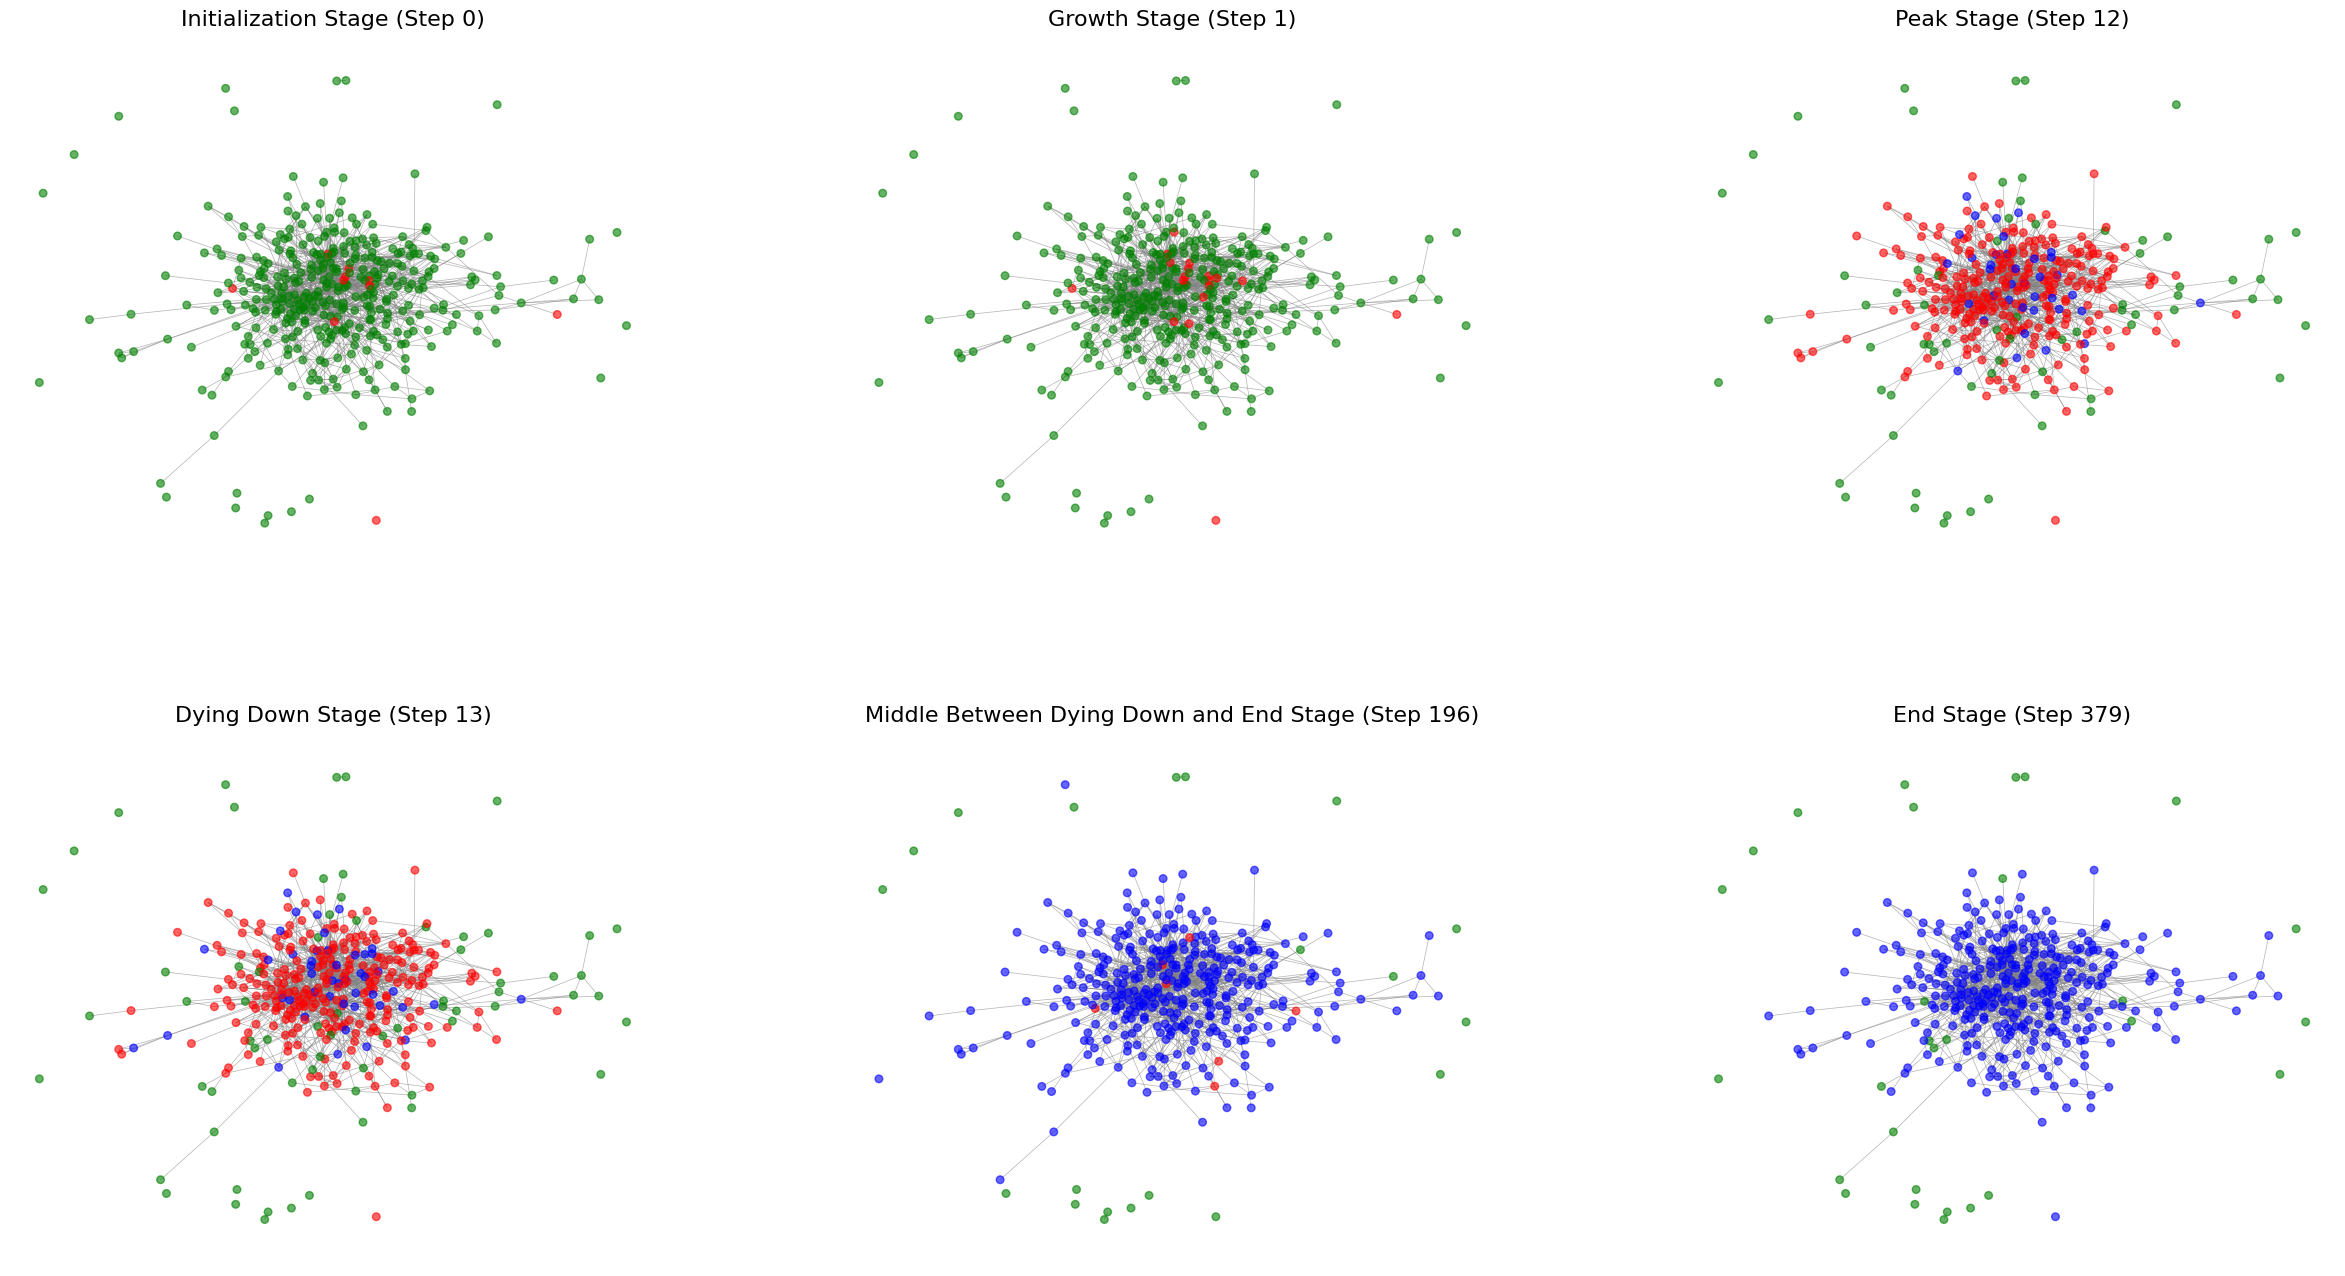

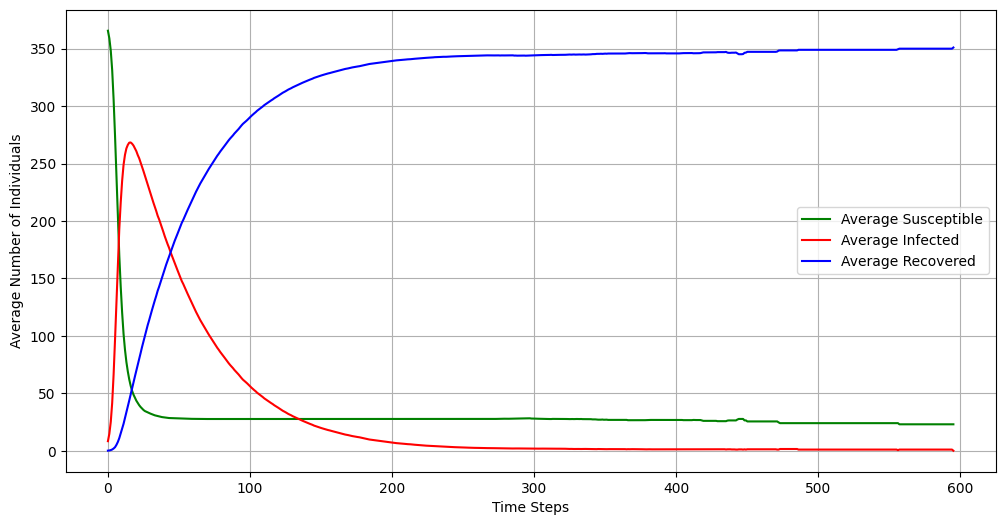

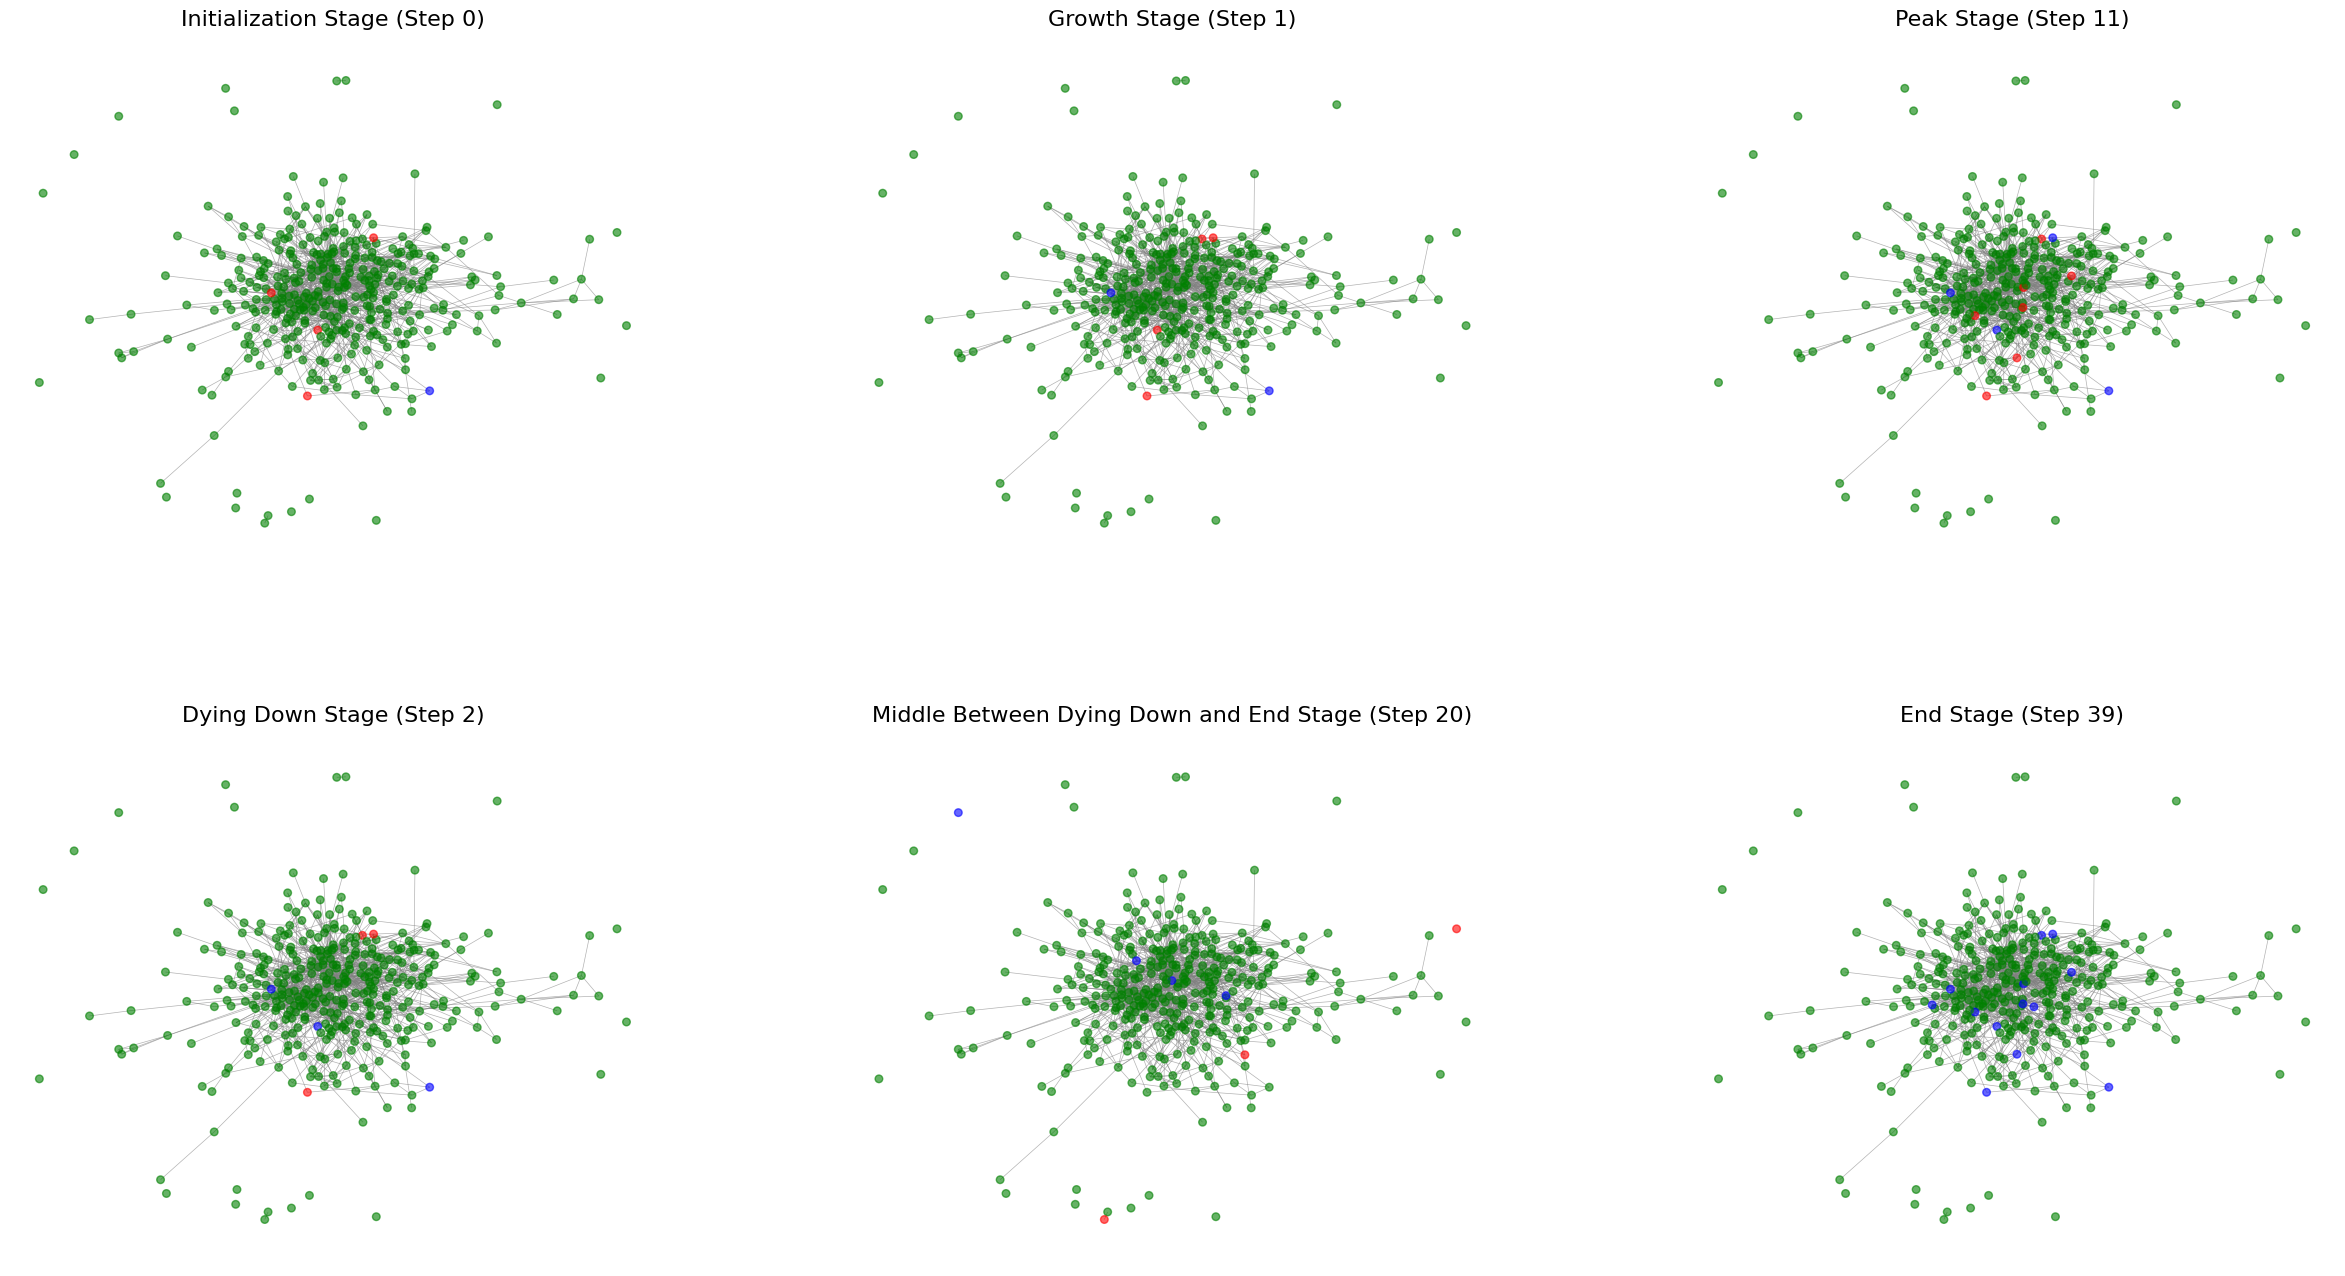

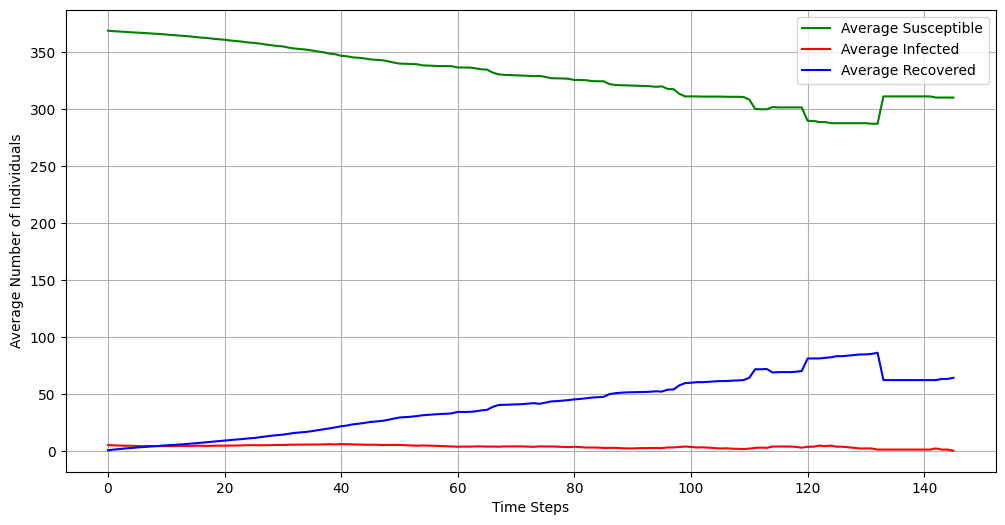

In [ ]:
"""
# 2.1
# Implement SIR disease spread on the network. Think about your experimental design
# and which parameters of the model you will want to vary. Design code that will allow
# you run multiple simulations while varying the disease parameter.
"""

def load_sociopatterns_dataset(filepath):
    # Load dataset and create a graph from the CSV file
    df = pd.read_csv(filepath, delimiter=';', index_col=0)
    print("CSV Loaded:")
    print(df.head())

    G = nx.Graph()  # Initialize a new graph
    nodes = set(df.index.astype(int)).union(map(int, df.columns))  # Get unique nodes
    G.add_nodes_from(nodes)  # Add nodes to the graph

    # Add edges to the graph based on non-zero weights in the DataFrame
    for source, row in df.iterrows():
        source = int(source)
        for target, weight in row.items():
            target = int(target)
            if weight > 0 and source != target:
                G.add_edge(source, target, weight=weight)

    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G  # Return the created graph

def initialize_sir(G, initial_infected_count=5):
    # Initialize the SIR model states for the nodes in the graph
    total_nodes = len(G.nodes())
    if total_nodes == 0:
        raise ValueError("The graph has no nodes.")  # Raise error if no nodes

    infected_count = min(initial_infected_count, total_nodes)  # Limit initial infected count

    # Set all nodes to susceptible state
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'

    # Randomly select nodes to be infected
    initial_infected = random.sample(list(G.nodes()), infected_count)
    for node in initial_infected:
        G.nodes[node]['state'] = 'I'  # Set selected nodes to infected

def sir_step(G, beta, gamma):
    # Perform one step of the SIR model
    new_infected = []  # List to store newly infected nodes
    new_recovered = []  # List to store newly recovered nodes

    for node in G.nodes():
        if G.nodes[node]['state'] == 'I':  # Check if the node is infected
            if random.random() < gamma:  # Recovery chance
                new_recovered.append(node)
            else:
                # Infect susceptible neighbors based on infection probability
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if G.nodes[neighbor]['state'] == 'S' and random.random() < beta:
                        new_infected.append(neighbor)  # Add to newly infected

    # Update states for newly infected and recovered nodes
    for node in new_infected:
        G.nodes[node]['state'] = 'I'
    for node in new_recovered:
        G.nodes[node]['state'] = 'R'

def run_averaged_simulation(G, beta, gamma, num_runs=100):
    # Run multiple simulations and calculate average counts
    max_steps = 0  # Track maximum number of time steps
    all_susceptible, all_infected, all_recovered = [], [], []  # Store results

    for _ in range(num_runs):
        susceptible_counts, infected_counts, recovered_counts = run_single_simulation(G, beta, gamma)

        max_steps = max(max_steps, len(susceptible_counts))  # Update maximum steps

        # Append results from each run
        all_susceptible.append(susceptible_counts)
        all_infected.append(infected_counts)
        all_recovered.append(recovered_counts)

    # Average the counts and plot results
    avg_susceptible = np.nanmean([np.concatenate([run, np.full((max_steps - len(run)), np.nan)]) for run in all_susceptible], axis=0)
    avg_infected = np.nanmean([np.concatenate([run, np.full((max_steps - len(run)), np.nan)]) for run in all_infected], axis=0)
    avg_recovered = np.nanmean([np.concatenate([run, np.full((max_steps - len(run)), np.nan)]) for run in all_recovered], axis=0)

    # Plot the average results
    plt.figure(figsize=(12, 6))
    plt.plot(avg_susceptible, label='Average Susceptible', color='green')
    plt.plot(avg_infected, label='Average Infected', color='red')
    plt.plot(avg_recovered, label='Average Recovered', color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Number of Individuals')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_single_simulation(G, beta, gamma):
    # Run a single simulation of the SIR model and return counts
    initialize_sir(G, initial_infected_count=5)
    susceptible_counts, infected_counts, recovered_counts = [], [], []

    while True:
        sir_step(G, beta, gamma)  # Perform one SIR step
        infected_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'I')  # Count infected
        recovered_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'R')  # Count recovered
        susceptible_count = len(G.nodes()) - infected_count - recovered_count  # Calculate susceptible

        # Append counts for this time step
        susceptible_counts.append(susceptible_count)
        infected_counts.append(infected_count)
        recovered_counts.append(recovered_count)

        if infected_count == 0:  # Check if the epidemic has ended
            break  # Exit the loop

    return susceptible_counts, infected_counts, recovered_counts  # Return counts

def run_visualization_simulation(G, beta, gamma):
    # Run a simulation and visualize key stages
    initialize_sir(G, initial_infected_count=5)  # Initialize the model

    # Prepare to capture snapshots at various stages
    snapshots = {
        "Initialization": None,
        "Growth": None,
        "Peak": None,
        "Dying Down": None,
        "Middle Between Dying Down and End": None,
        "End": None
    }
    snapshot_steps = {}

    max_infected = 0  # Track the maximum infected count
    step = 0  # Initialize step counter

    while True:
        sir_step(G, beta, gamma)  # Step the SIR model
        infected_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'I')  # Count infected

        # Capture snapshots based on the infection dynamics
        if step == 0:
            snapshots["Initialization"] = G.copy()
            snapshot_steps["Initialization"] = step
        elif infected_count > max_infected:
            if snapshots["Growth"] is None:
                snapshots["Growth"] = G.copy()
                snapshot_steps["Growth"] = step
            max_infected = infected_count
            snapshots["Peak"] = G.copy()
            snapshot_steps["Peak"] = step
        elif infected_count < max_infected and snapshots["Dying Down"] is None:
            snapshots["Dying Down"] = G.copy()
            snapshot_steps["Dying Down"] = step
        elif infected_count == 0:  # End of simulation
            snapshots["End"] = G.copy()
            snapshot_steps["End"] = step
            break

        step += 1  # Increment the step counter

    # Calculate midpoint step
    dying_down_step = snapshot_steps["Dying Down"]
    end_step = snapshot_steps["End"]
    midpoint_step = (dying_down_step + end_step) // 2

    # Re-initialize and run to midpoint for final snapshot
    initialize_sir(G, initial_infected_count=5)
    for current_step in range(midpoint_step + 1):
        sir_step(G, beta, gamma)
        if current_step == midpoint_step:
            snapshots["Middle Between Dying Down and End"] = G.copy()
            snapshot_steps["Middle Between Dying Down and End"] = current_step
            break

    # Visualization of the snapshots
    fig, axs = plt.subplots(2, 3, figsize=(30, 16))

    titles = ["Initialization", "Growth", "Peak", "Dying Down", "Middle Between Dying Down and End", "End"]

    for i, stage in enumerate(titles):
        row, col = divmod(i, 3)
        time_step = snapshot_steps[stage]
        pos = nx.spring_layout(snapshots[stage], seed=42, k=0.4, iterations=50)
        state_colors = {'S': 'green', 'I': 'red', 'R': 'blue'}
        node_colors = [state_colors[snapshots[stage].nodes[node]['state']] for node in snapshots[stage].nodes()]

        # Draw the graph
        nx.draw_networkx(
            snapshots[stage], pos, node_color=node_colors, with_labels=False,
            node_size=30, edge_color='gray', width=0.5, alpha=0.6, ax=axs[row, col]
        )
        axs[row, col].set_title(f'{stage} Stage (Step {time_step})', fontsize=16)
        axs[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

# Load the dataset and create the graph
filepath = '/content/transmission_network.csv'
G = load_sociopatterns_dataset(filepath)  # Load the sociopatterns dataset

# Epidemic Scenario
beta = 0.1  # Set infection rate for epidemic scenario
gamma = 0.02  # Set recovery rate for epidemic scenario
run_visualization_simulation(G, beta, gamma)  # Run visualization for epidemic scenario
run_averaged_simulation(G, beta, gamma, num_runs=100)  # Run averaged simulation for epidemic scenario

# Non-Epidemic Scenario
beta = 0.01  # Set infection rate for non-epidemic scenario
gamma = 0.1  # Set recovery rate for non-epidemic scenario
run_visualization_simulation(G, beta, gamma)  # Run visualization for non-epidemic scenario
run_averaged_simulation(G, beta, gamma, num_runs=100)  # Run averaged simulation for non-epidemic scenario


# **Chapter** 2.2

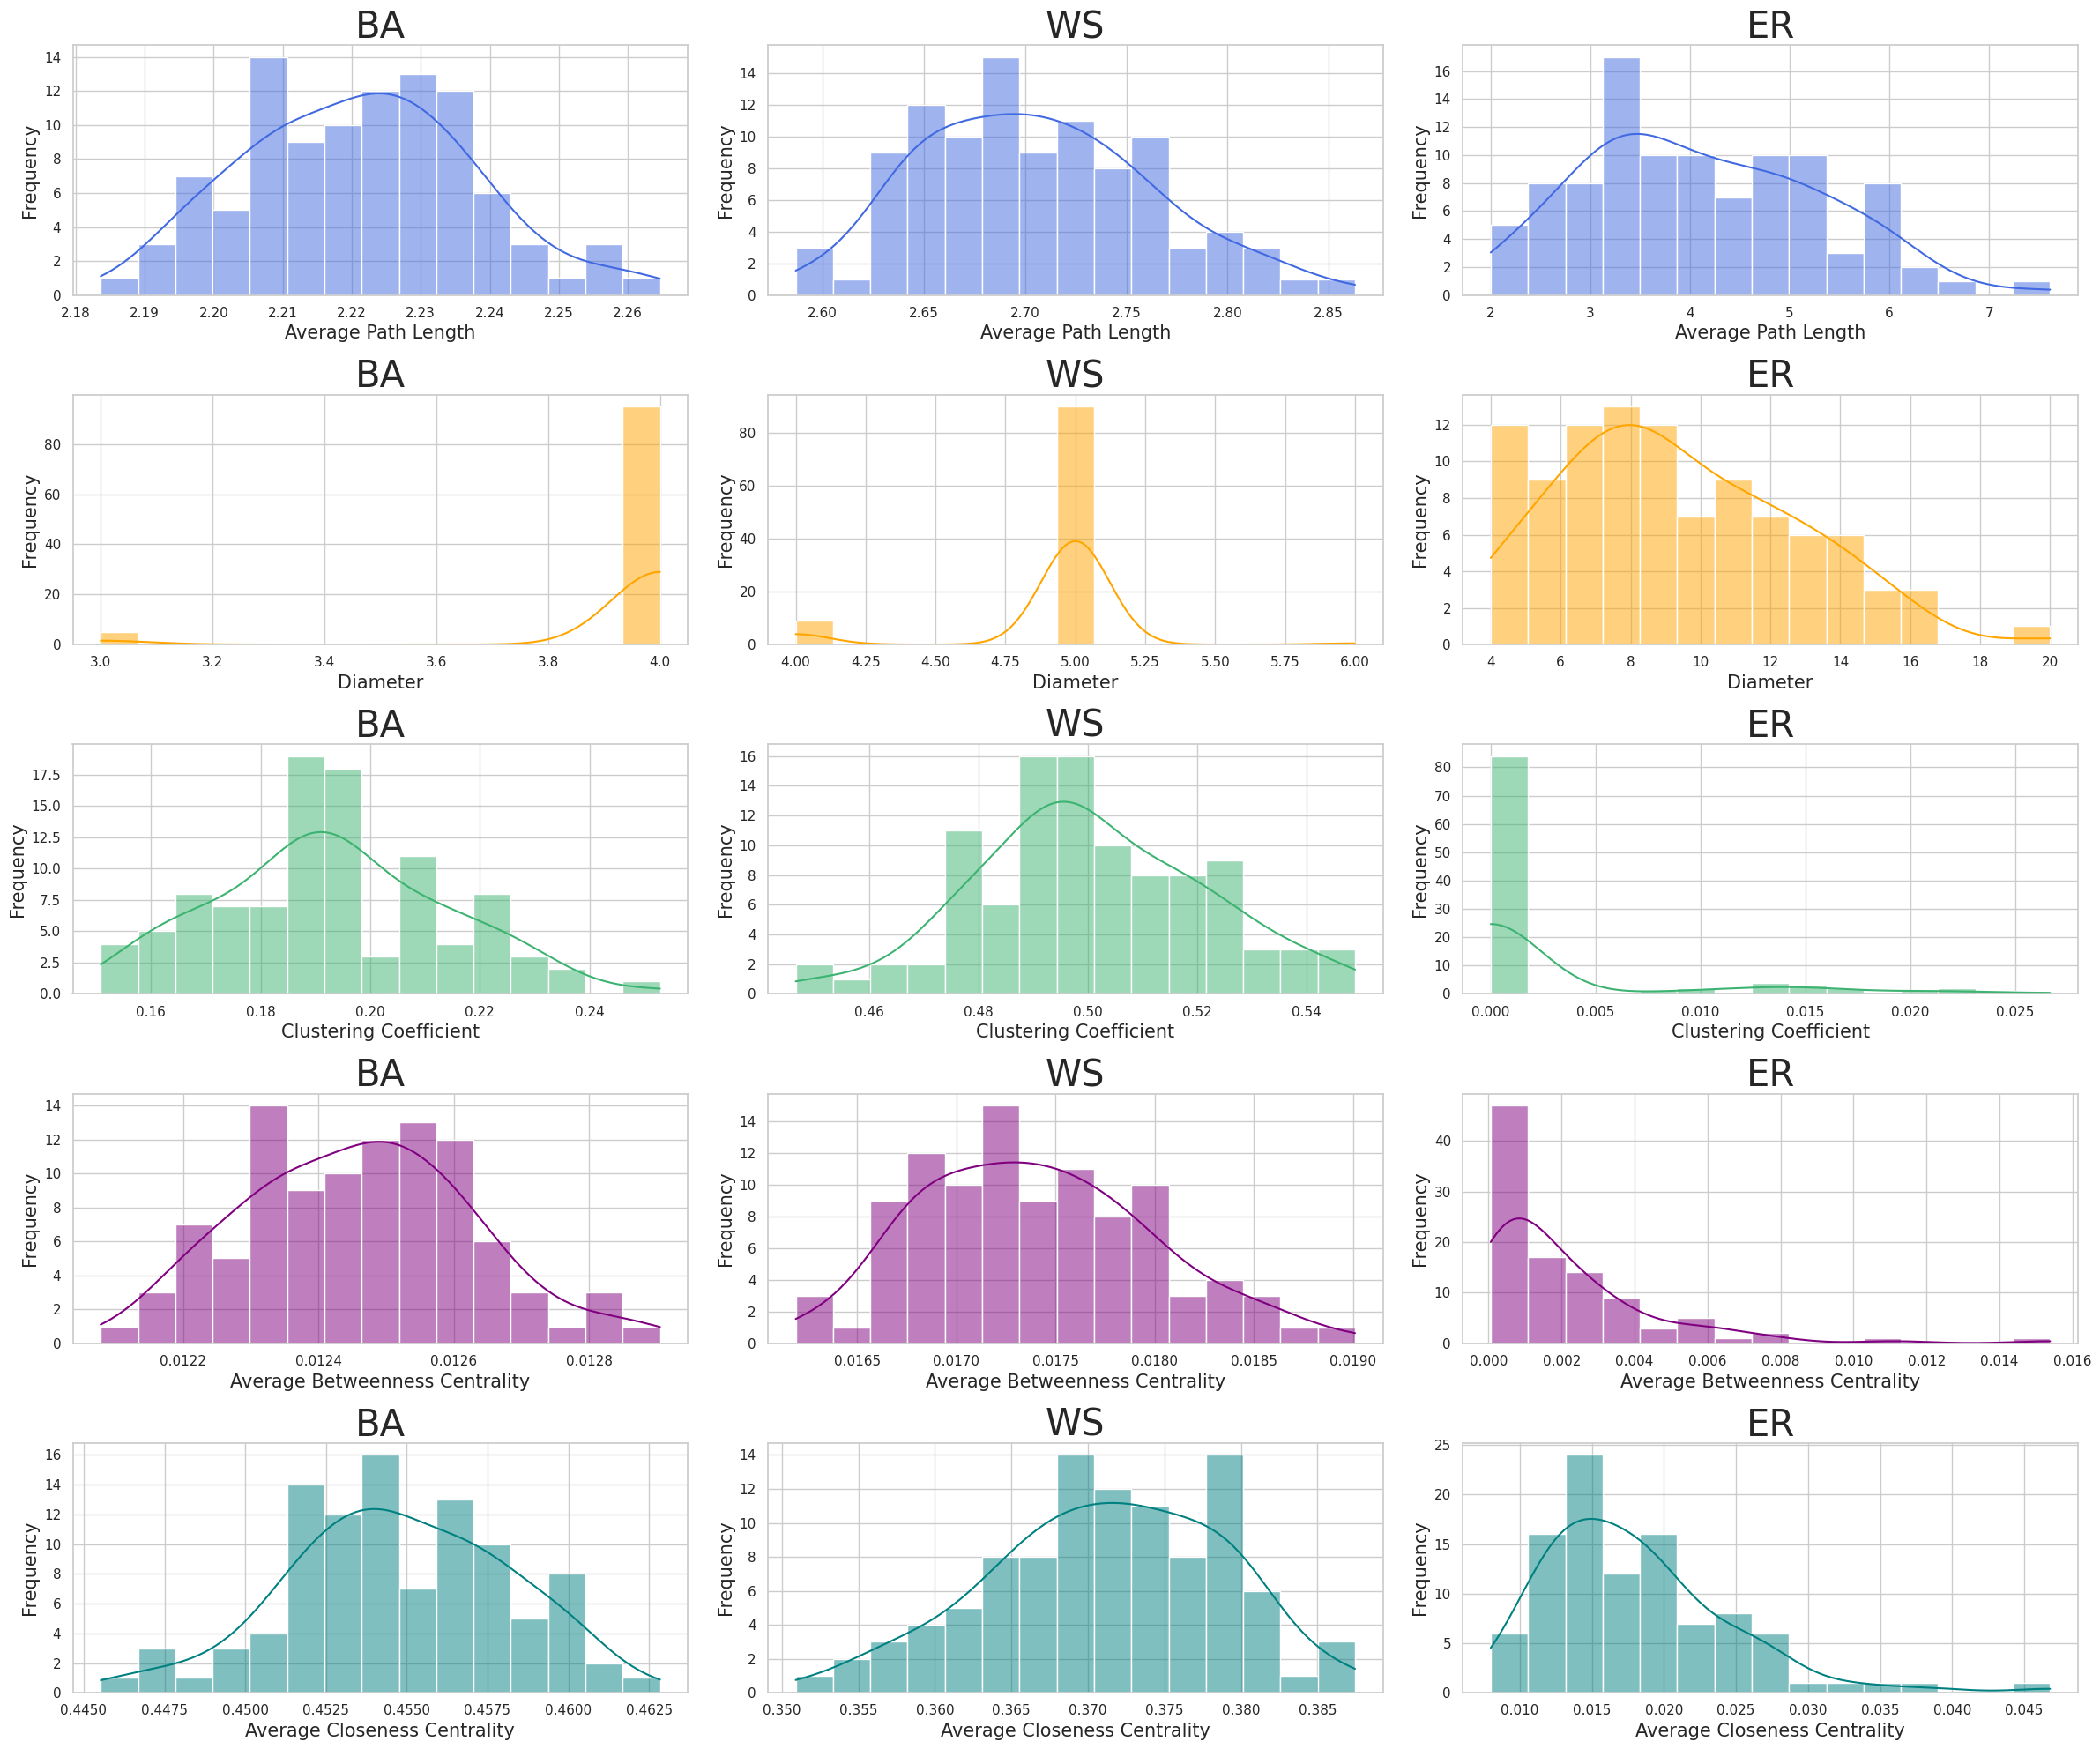

In [ ]:
# 2.2, Plotting Network Stats for our three main types of networks (BA, ER, WS)
"""
Using NetworkX generate multiple model networks with similar characteristics, again
think about the parameters associated with each network generator (e.g., Number of
nodes, connection probability,etc). Pick some network statistics (e.g., centrality measures,
degree distributions, etc.) that are interesting to measure in terms of spreading on the
network. You should generate multiple instances of each network type and then plot the
network statistics (you chose) and discuss how these statistic differ between network types
and for different parameter settings. You will use these generated networks in your SIR
experiments in the next part.
"""

# Set the seaborn style for plots
sns.set(style='whitegrid')

def generate_network(network_type, num_nodes):
    # Generate a network based on the specified type
    if network_type == 'BA':
        return nx.barabasi_albert_graph(n=num_nodes, m=5)  # Barabási-Albert model
    elif network_type == 'WS':
        return nx.watts_strogatz_graph(n=num_nodes, k=10, p=0.1)  # Watts-Strogatz model
    elif network_type == 'ER':
        return nx.erdos_renyi_graph(n=num_nodes, p=0.01)  # Erdős-Rényi model

def calculate_network_statistics(G):
    # Calculate various statistics for the given network
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)  # Average path length
        diameter = nx.diameter(G)  # Diameter of the network
    else:
        largest_cc = max(nx.connected_components(G), key=len)  # Largest connected component
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        diameter = nx.diameter(subgraph)

    clustering_coefficient = nx.average_clustering(G)  # Clustering coefficient
    betweenness = nx.betweenness_centrality(G)  # Betweenness centrality
    avg_betweenness = np.mean(list(betweenness.values()))  # Average betweenness centrality

    closeness = nx.closeness_centrality(G)  # Closeness centrality
    avg_closeness = np.mean(list(closeness.values()))  # Average closeness centrality

    return (avg_path_length, diameter, clustering_coefficient, avg_betweenness, avg_closeness)  # Return statistics

num_nodes = 100  # Number of nodes in each network
num_instances = 100  # Number of instances to generate for each type

# Dictionary to store statistics for each network type
network_stats = {network_type: [] for network_type in ['BA', 'WS', 'ER']}

# Generate networks and calculate statistics for each type
for network_type in ['BA', 'WS', 'ER']:
    stats = []
    for _ in range(num_instances):
        G = generate_network(network_type, num_nodes)  # Generate the network
        stats.append(calculate_network_statistics(G))  # Calculate statistics
    network_stats[network_type] = stats  # Store statistics for the network type

# Extract statistics for plotting
avg_path_lengths = {nt: [stat[0] for stat in network_stats[nt]] for nt in network_stats}
diameters = {nt: [stat[1] for stat in network_stats[nt]] for nt in network_stats}
clustering_coefficients = {nt: [stat[2] for stat in network_stats[nt]] for nt in network_stats}
avg_betweennesses = {nt: [stat[3] for stat in network_stats[nt]] for nt in network_stats}
avg_closenesses = {nt: [stat[4] for stat in network_stats[nt]] for nt in network_stats}

def plot_statistics_side_by_side():
    # Plot the network statistics side by side for comparison
    fig, axs = plt.subplots(5, 3, figsize=(24, 20))  # Create subplots
    statistics = [
        (avg_path_lengths, 'Average Path Length', 'royalblue'),
        (diameters, 'Diameter', 'orange'),
        (clustering_coefficients, 'Clustering Coefficient', 'mediumseagreen'),
        (avg_betweennesses, 'Average Betweenness Centrality', 'purple'),
        (avg_closenesses, 'Average Closeness Centrality', 'teal')
    ]
    network_types = ['BA', 'WS', 'ER']

    # Generate histograms for each statistic
    for row, (stat_dict, title, color) in enumerate(statistics):
        for col, network_type in enumerate(network_types):
            sns.histplot(stat_dict[network_type], kde=True, ax=axs[row, col], color=color, bins=15)
            axs[row, col].set_title(f'{network_type}', fontsize=30)  # Title for each subplot
            axs[row, col].set_xlabel(title, fontsize=15)  # X-axis label
            axs[row, col].set_ylabel('Frequency', fontsize=15)  # Y-axis label
            axs[row, col].grid(True)  # Enable grid for better readability

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plots

plot_statistics_side_by_side()  # Call the function to plot statistics


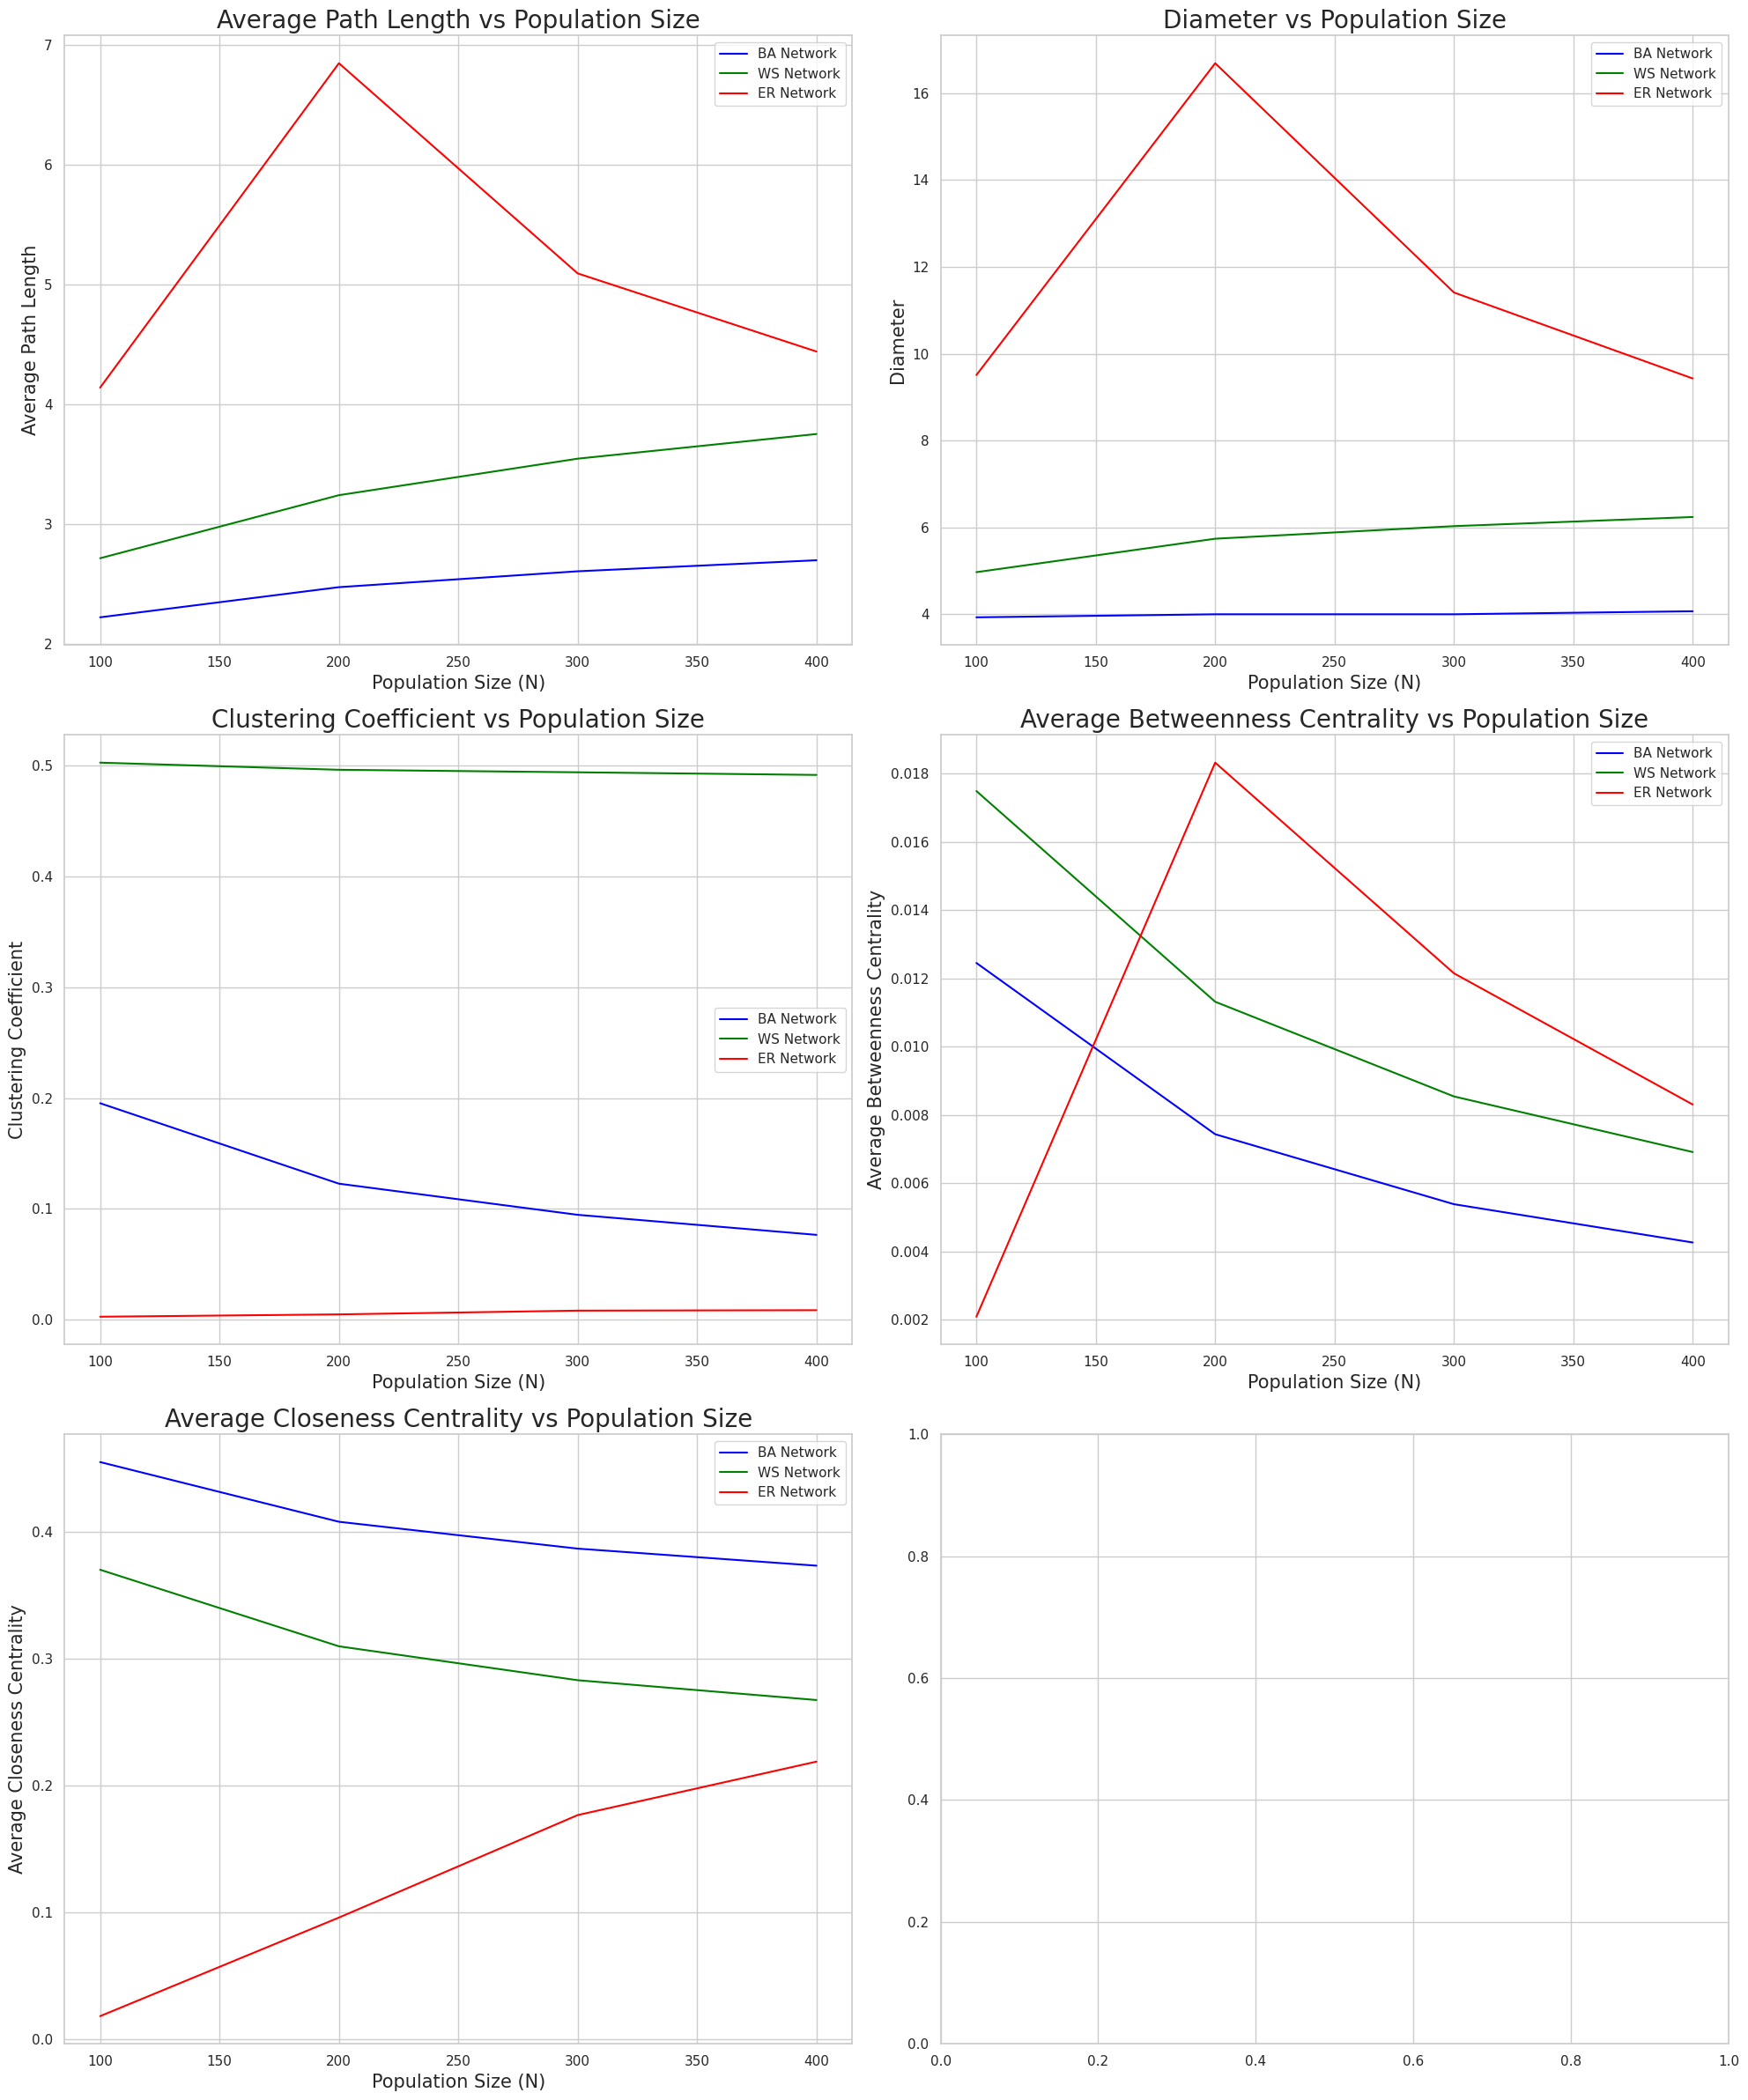

In [ ]:
# 2.2, Plotting network stats against population sizes.

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style for plots
sns.set(style='whitegrid')

def generate_network(network_type, num_nodes):
    # Generate a network based on the specified type and number of nodes
    if network_type == 'BA':
        return nx.barabasi_albert_graph(n=num_nodes, m=5)  # Barabási-Albert model
    elif network_type == 'WS':
        return nx.watts_strogatz_graph(n=num_nodes, k=10, p=0.1)  # Watts-Strogatz model
    elif network_type == 'ER':
        return nx.erdos_renyi_graph(n=num_nodes, p=0.01)  # Erdős-Rényi model

def calculate_network_statistics(G):
    # Calculate statistics for the given network
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)  # Average path length
        diameter = nx.diameter(G)  # Diameter of the network
    else:
        largest_cc = max(nx.connected_components(G), key=len)  # Largest connected component
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        diameter = nx.diameter(subgraph)

    clustering_coefficient = nx.average_clustering(G)  # Clustering coefficient
    betweenness = nx.betweenness_centrality(G)  # Betweenness centrality
    avg_betweenness = np.mean(list(betweenness.values()))  # Average betweenness centrality

    closeness = nx.closeness_centrality(G)  # Closeness centrality
    avg_closeness = np.mean(list(closeness.values()))  # Average closeness centrality

    return (avg_path_length, diameter, clustering_coefficient, avg_betweenness, avg_closeness)  # Return all statistics

num_instances = 100  # Number of instances to generate for each network type
population_sizes = [100, 200, 300, 400]  # Different population sizes for the networks

# Dictionary to store statistics for each network type
network_stats = {network_type: {n: [] for n in population_sizes} for network_type in ['BA', 'WS', 'ER']}

# Generate networks and calculate statistics for each type and population size
for network_type in ['BA', 'WS', 'ER']:
    for n in population_sizes:
        stats = []
        for _ in range(num_instances):
            G = generate_network(network_type, n)  # Generate the network
            stats.append(calculate_network_statistics(G))  # Calculate and store statistics
        network_stats[network_type][n] = stats  # Store statistics by population size

# Extract averages for plotting
avg_path_lengths = {network_type: [np.mean([stat[0] for stat in network_stats[network_type][n]]) for n in population_sizes] for network_type in ['BA', 'WS', 'ER']}
diameters = {network_type: [np.mean([stat[1] for stat in network_stats[network_type][n]]) for n in population_sizes] for network_type in ['BA', 'WS', 'ER']}
clustering_coefficients = {network_type: [np.mean([stat[2] for stat in network_stats[network_type][n]]) for n in population_sizes] for network_type in ['BA', 'WS', 'ER']}
avg_betweennesses = {network_type: [np.mean([stat[3] for stat in network_stats[network_type][n]]) for n in population_sizes] for network_type in ['BA', 'WS', 'ER']}
avg_closenesses = {network_type: [np.mean([stat[4] for stat in network_stats[network_type][n]]) for n in population_sizes] for network_type in ['BA', 'WS', 'ER']}

def plot_statistics_vs_population_size():
    # Plot network statistics against population sizes
    fig, axs = plt.subplots(3, 2, figsize=(20, 24))  # Create subplots
    statistics = [
        (avg_path_lengths, 'Average Path Length'),
        (diameters, 'Diameter'),
        (clustering_coefficients, 'Clustering Coefficient'),
        (avg_betweennesses, 'Average Betweenness Centrality'),
        (avg_closenesses, 'Average Closeness Centrality')
    ]
    network_types = ['BA', 'WS', 'ER']  # Network types for plotting
    colors = {'BA': 'blue', 'WS': 'green', 'ER': 'red'}  # Color mapping for network types

    # Plot each statistic for all network types
    for i, (stat_dict, title) in enumerate(statistics):
        row, col = divmod(i, 2)  # Determine subplot position
        for network_type in network_types:
            axs[row, col].plot(population_sizes, stat_dict[network_type], label=f'{network_type} Network', color=colors[network_type])  # Plot data
        axs[row, col].set_title(f'{title} vs Population Size', fontsize=20)  # Title for subplot
        axs[row, col].set_xlabel('Population Size (N)', fontsize=15)  # X-axis label
        axs[row, col].set_ylabel(title, fontsize=15)  # Y-axis label
        axs[row, col].legend()  # Show legend
        axs[row, col].grid(True)  # Enable grid for clarity

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the plots

plot_statistics_vs_population_size()  # Call the function to plot statistics


# **Chapter** 2.3

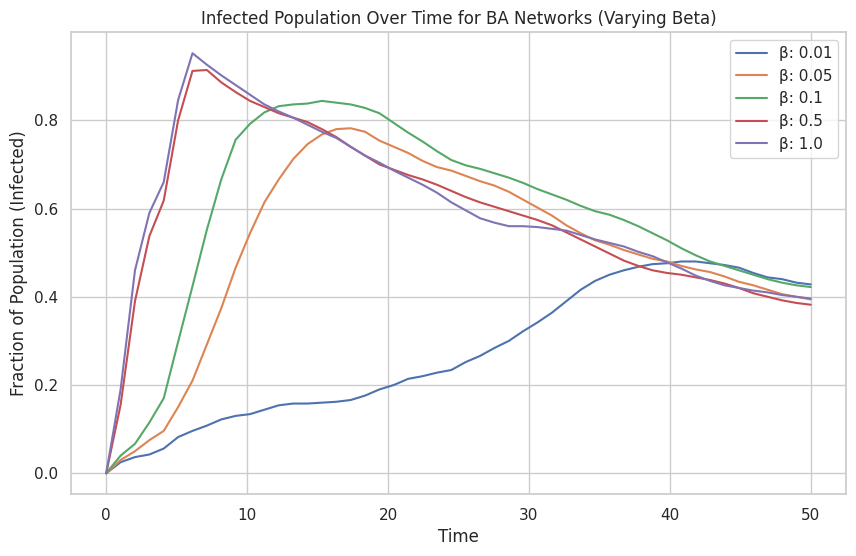

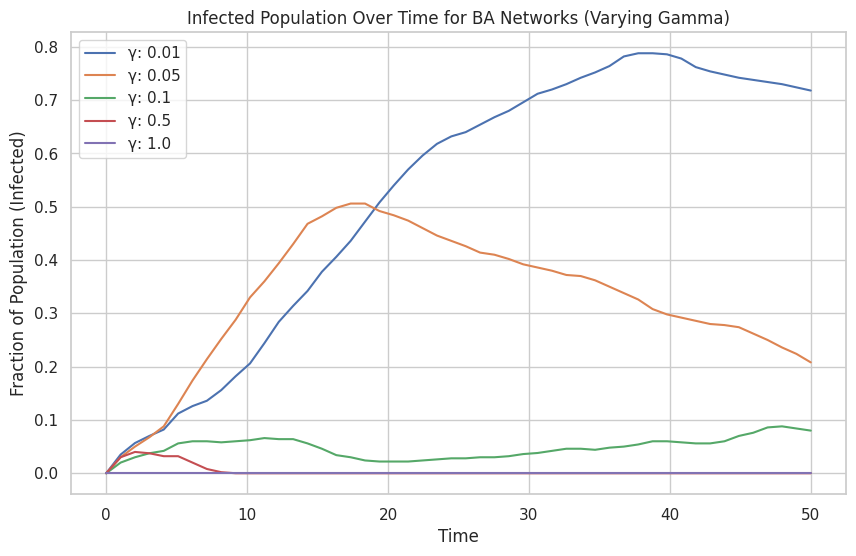

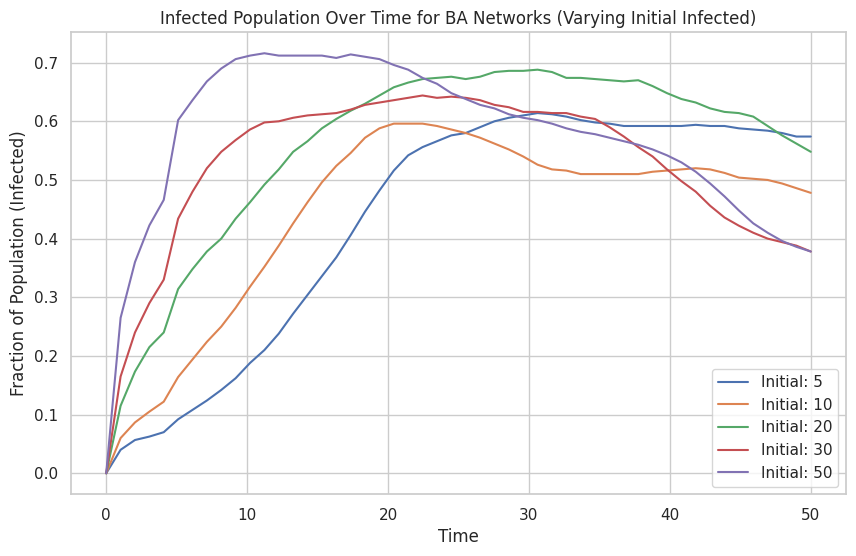

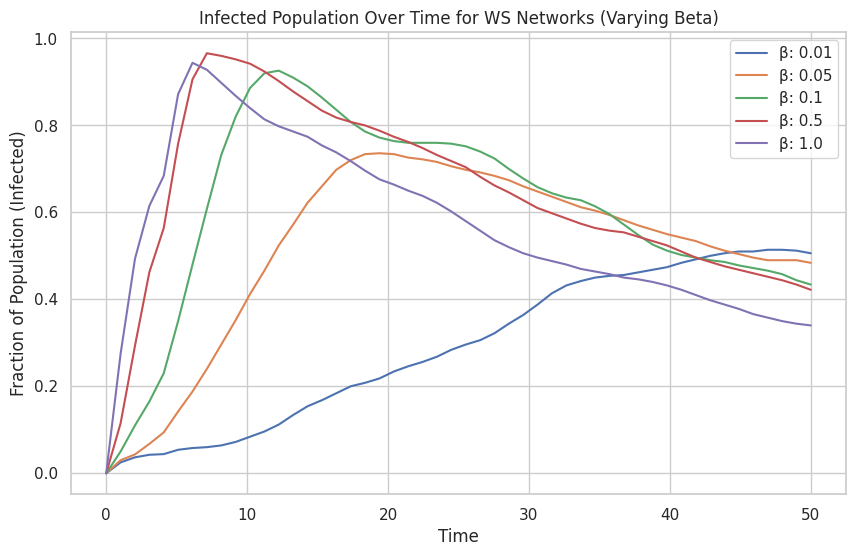

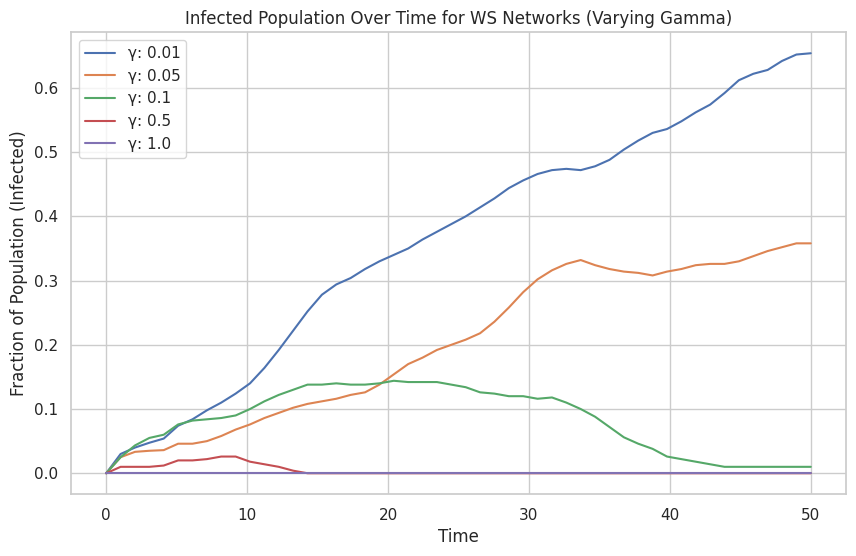

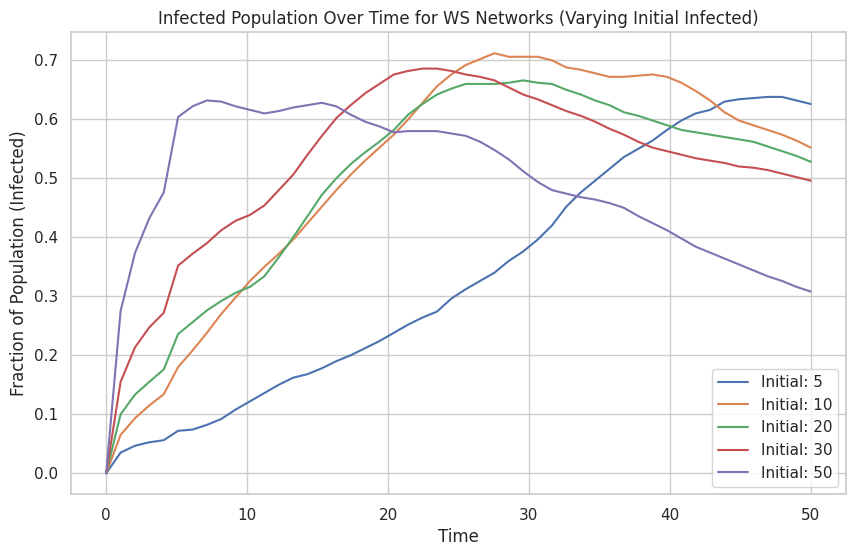

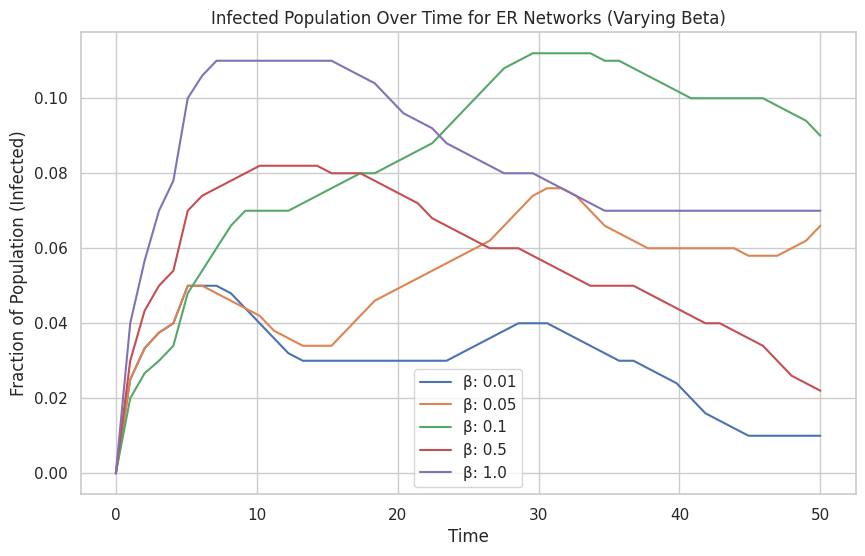

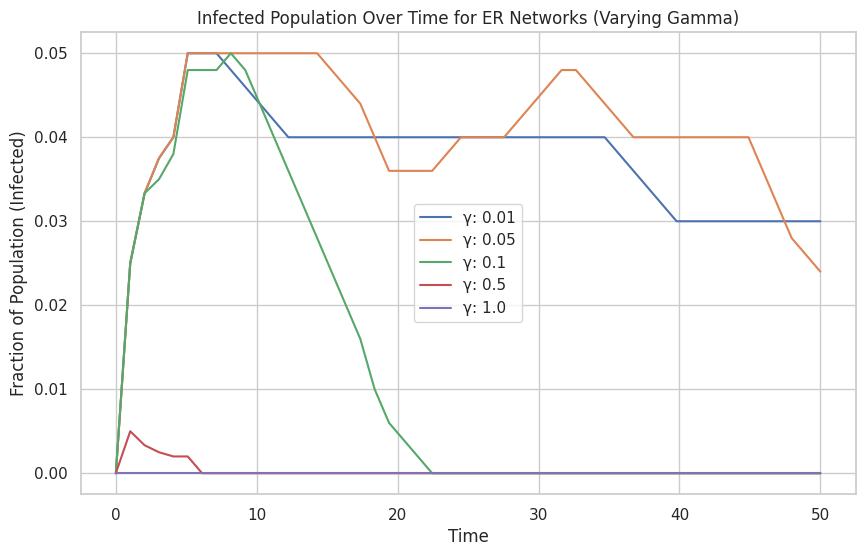

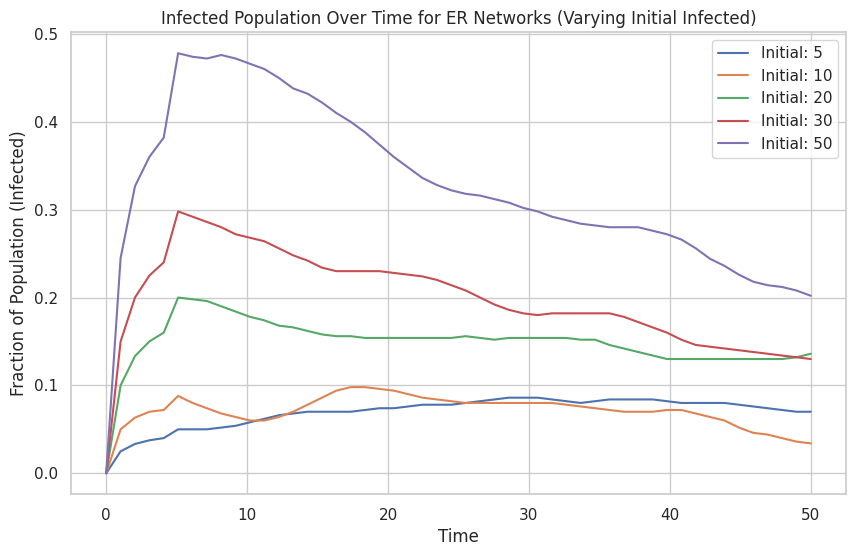

In [ ]:
# 2.3, Plotting Network Infected Dynamics against each other.
"""
Simulate epidemic spreading on the networks you generated in the previous section
(NOTE: the simulations will be stochastic so think about random seeds and repitions).
You can vary the fraction of initial infected, which nodes are initially infected and other
disease parameters. Compare and discuss how the disease spreads in the different networks
under different conditions
"""

# Set seaborn style for plots
sns.set(style='whitegrid')

def generate_network(network_type, num_nodes):
    # Generate a network based on the specified type and number of nodes
    if network_type == 'BA':
        return nx.barabasi_albert_graph(n=num_nodes, m=5)  # Barabási-Albert model
    elif network_type == 'WS':
        return nx.watts_strogatz_graph(n=num_nodes, k=10, p=0.1)  # Watts-Strogatz model
    elif network_type == 'ER':
        return nx.erdos_renyi_graph(n=num_nodes, p=0.01)  # Erdős-Rényi model

def initialize_sir(G, initial_infected_fraction):
    # Initialize the SIR model states for the nodes in the graph
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'  # Set all nodes to susceptible
    initial_infected = random.sample(list(G.nodes()), int(initial_infected_fraction * len(G.nodes())))  # Randomly select infected nodes
    for node in initial_infected:
        G.nodes[node]['state'] = 'I'  # Set selected nodes to infected

def sir_step(G, beta, gamma):
    # Perform one step of the SIR model
    new_infected = []  # List to store newly infected nodes
    new_recovered = []  # List to store newly recovered nodes

    for node in G.nodes():
        if G.nodes[node]['state'] == 'I':
            if random.random() < gamma:  # Recovery chance
                new_recovered.append(node)
            else:
                # Infect susceptible neighbors based on infection probability
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if G.nodes[neighbor]['state'] == 'S' and random.random() < beta:
                        new_infected.append(neighbor)  # Add to newly infected

    # Update states for newly infected and recovered nodes
    for node in new_infected:
        G.nodes[node]['state'] = 'I'
    for node in new_recovered:
        G.nodes[node]['state'] = 'R'

def run_simulation(network, initial_infected_fraction, beta, gamma, initial_population, t):
    # Run the SIR simulation for a given network
    initialize_sir(network, initial_infected_fraction)  # Initialize the model

    infected_network = [0.0]  # Store infected fraction over time

    for time_step in range(len(t) - 1):
        sir_step(network, beta, gamma)  # Step the SIR model
        infected_count = len([node for node in network if network.nodes[node]['state'] == 'I']) / len(network)  # Calculate infected fraction
        infected_network.append(infected_count)  # Store infected fraction

    return infected_network  # Return the list of infected fractions

def apply_rolling_average(data, window_size=5):
    # Calculate rolling average for the provided data
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()

num_nodes = 100  # Number of nodes for each network
# Generate networks of different types
networks = {
    'BA': generate_network('BA', num_nodes),
    'WS': generate_network('WS', num_nodes),
    'ER': generate_network('ER', num_nodes)
}

# Define parameter values for beta, gamma, and initial population
beta_values = [0.01, 0.05, 0.1, 0.5, 1.0]
gamma_values = [0.01, 0.05, 0.1, 0.5, 1.0]
initial_populations = [5, 10, 20, 30, 50]

constant_gamma = 0.02  # Fixed gamma value for varying beta scenarios
constant_initial_population = 5  # Fixed initial population for varying beta and gamma scenarios

def plot_infected(network_type, beta_values, gamma_values, initial_populations):
    # Plot the infected dynamics for varying beta, gamma, and initial infected
    initial_infected_fraction = constant_initial_population / num_nodes  # Fraction of initially infected

    # Plot for varying beta
    plt.figure(figsize=(10, 6))
    for beta in beta_values:
        infected_data = run_simulation(networks[network_type], initial_infected_fraction, beta, constant_gamma, constant_initial_population, np.linspace(0, 50, 50))
        infected_data_smoothed = apply_rolling_average(infected_data)  # Smooth the data
        plt.plot(np.linspace(0, 50, 50), infected_data_smoothed, label=f'β: {beta}')  # Plot smoothed data
    plt.title(f'Infected Population Over Time for {network_type} Networks (Varying Beta)')
    plt.xlabel('Time')
    plt.ylabel('Fraction of Population (Infected)')
    plt.legend()
    plt.show()

    # Plot for varying gamma
    plt.figure(figsize=(10, 6))
    for gamma in gamma_values:
        infected_data = run_simulation(networks[network_type], initial_infected_fraction, constant_gamma, gamma, constant_initial_population, np.linspace(0, 50, 50))
        infected_data_smoothed = apply_rolling_average(infected_data)  # Smooth the data
        plt.plot(np.linspace(0, 50, 50), infected_data_smoothed, label=f'γ: {gamma}')  # Plot smoothed data
    plt.title(f'Infected Population Over Time for {network_type} Networks (Varying Gamma)')
    plt.xlabel('Time')
    plt.ylabel('Fraction of Population (Infected)')
    plt.legend()
    plt.show()

    # Plot for varying initial infected
    plt.figure(figsize=(10, 6))
    for initial_population in initial_populations:
        initial_infected_fraction = initial_population / num_nodes  # Update initial infected fraction
        infected_data = run_simulation(networks[network_type], initial_infected_fraction, constant_gamma, constant_gamma, initial_population, np.linspace(0, 50, 50))
        infected_data_smoothed = apply_rolling_average(infected_data)  # Smooth the data
        plt.plot(np.linspace(0, 50, 50), infected_data_smoothed, label=f'Initial: {initial_population}')  # Plot smoothed data
    plt.title(f'Infected Population Over Time for {network_type} Networks (Varying Initial Infected)')
    plt.xlabel('Time')
    plt.ylabel('Fraction of Population (Infected)')
    plt.legend()
    plt.show()

# Run plotting function for each network type
for network_type in ['BA', 'WS', 'ER']:
    plot_infected(network_type, beta_values, gamma_values, initial_populations)  # Call the function to plot dynamics


# **Chapter** 2.4

<ipython-input-5-7fb96b44cccd>:48: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  tested_nodes = random.sample(G.nodes(), min(vaccination_budget, len(G.nodes())))


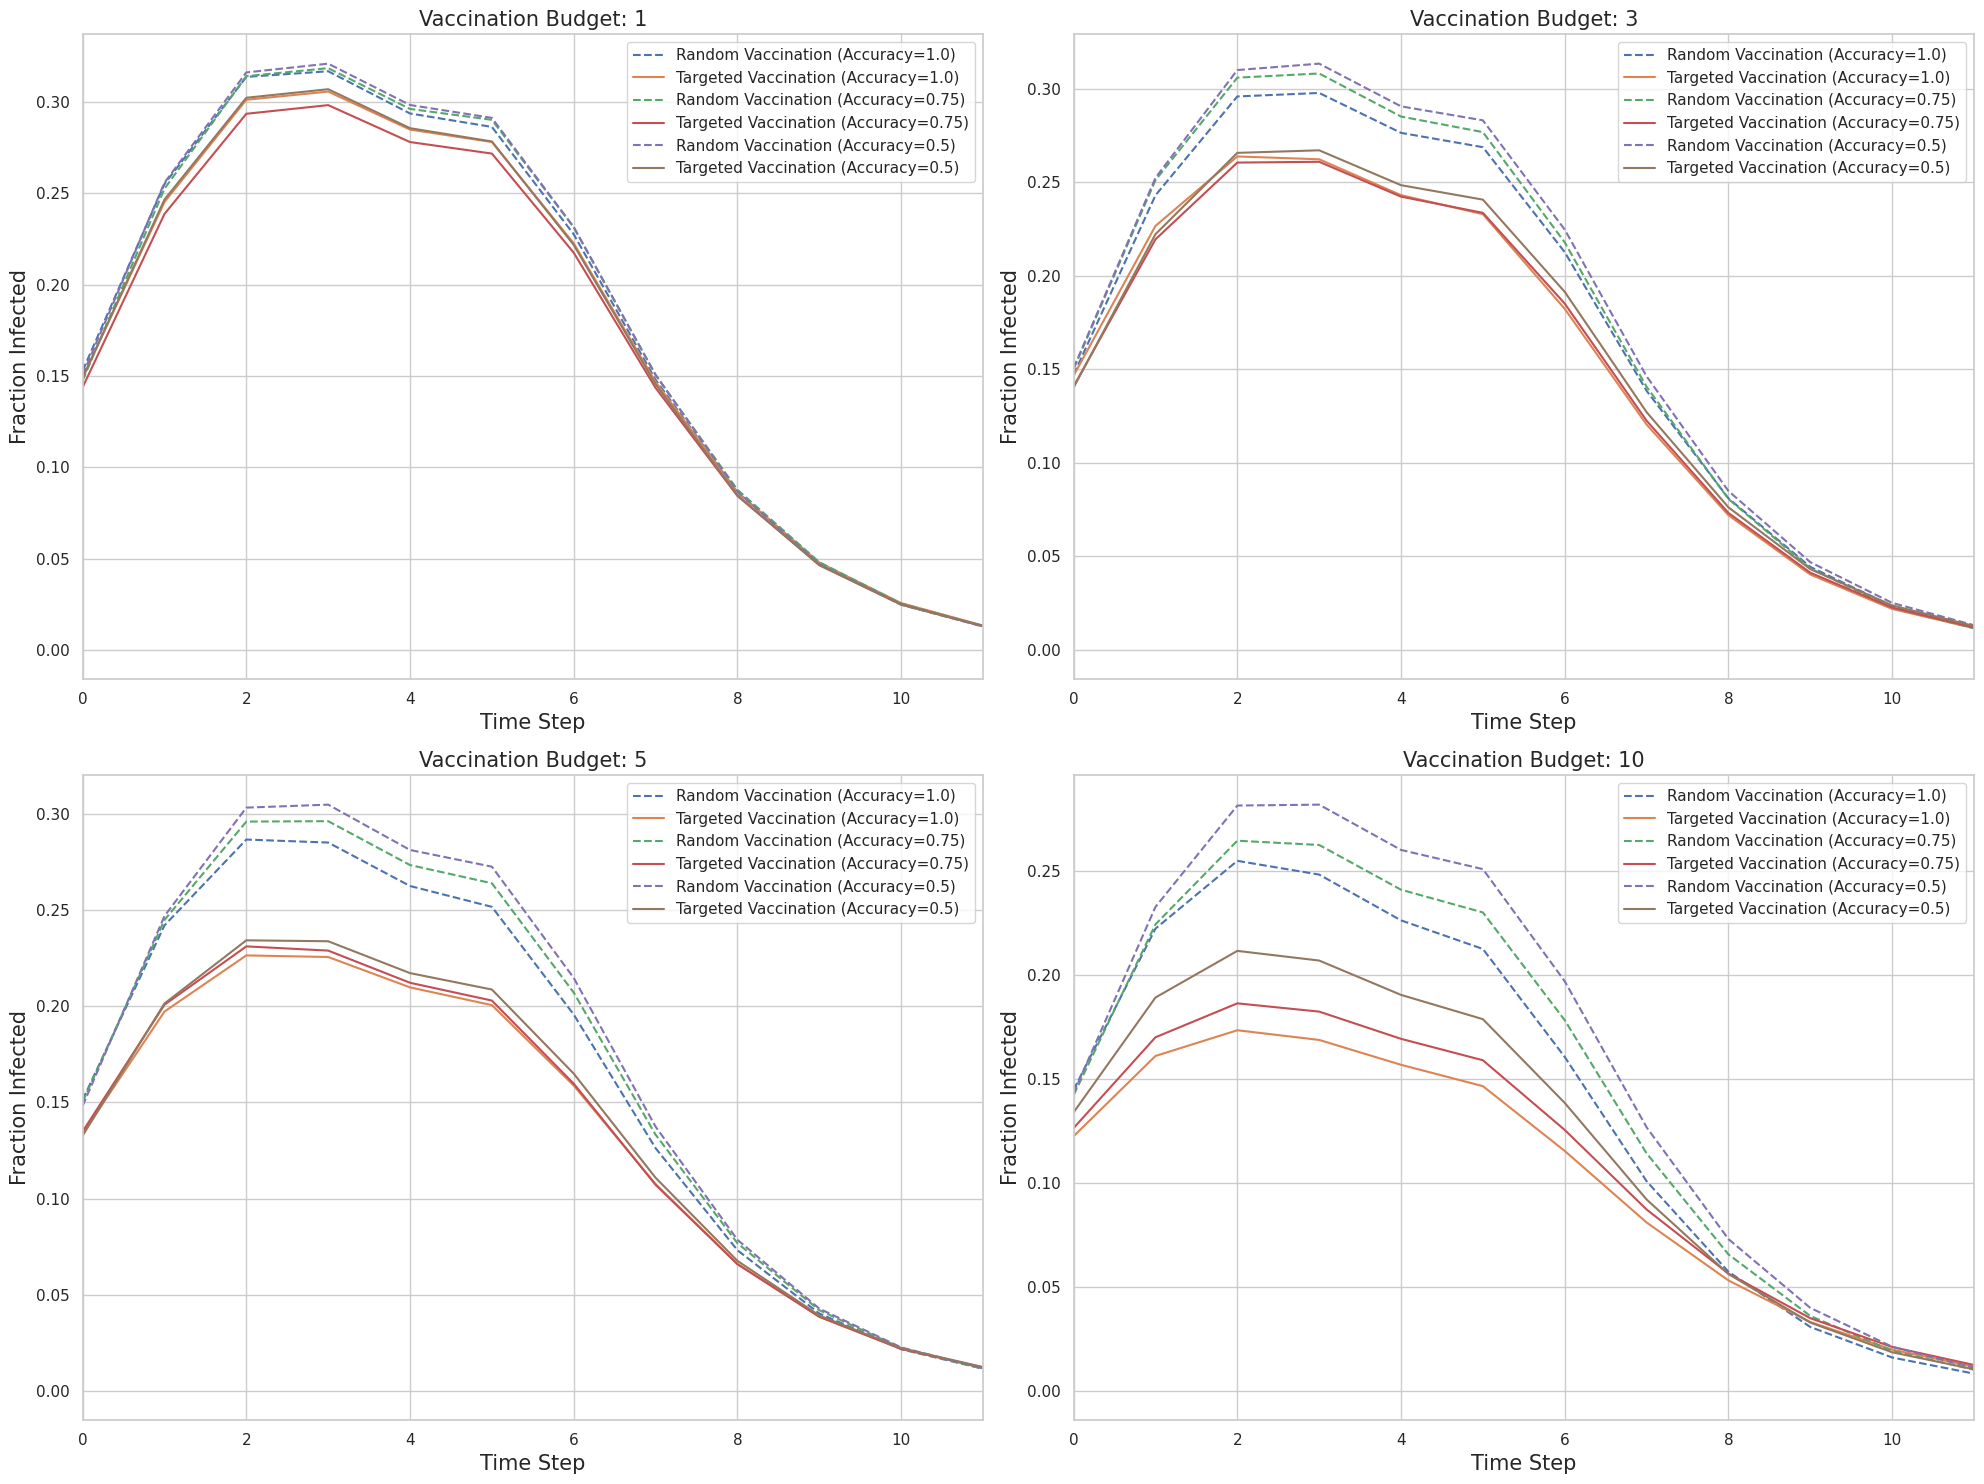

In [ ]:
# 2.4
"""
You are to design a dynamic vaccination strategy in which you have a testing budget and
a limited number of vaccinations available per iteration of the model. Assume that you
have 200 tests in total, you can use a maximum number of tests per iteration (this will
vary per experiment see below), you can of course use less. You can use the tests at any
point during the spread and you may repeat tests on a node as often as you like. You
can assume that you know the network structure, but you can only discover the disease
status of a node after a test. Vaccinations can only be applied to susceptible people and
that they immediately move people to the removed state. Finally, you might consider
situations where the tests are not always accurate, but instead have some probability
(which you can vary) of being accurate. You can also assume that people remain removed
until the end of the simulation (no waning immunity).
"""

# Set seaborn style for plots
sns.set(style='whitegrid')

def generate_network(network_type, num_nodes):
    # Generate a network based on the specified type and number of nodes
    if network_type == 'BA':
        return nx.barabasi_albert_graph(n=num_nodes, m=5)  # Barabási-Albert model
    elif network_type == 'WS':
        return nx.watts_strogatz_graph(n=num_nodes, k=10, p=0.1)  # Watts-Strogatz model
    elif network_type == 'ER':
        return nx.erdos_renyi_graph(n=num_nodes, p=0.01)  # Erdős-Rényi model

def initialize_sir(G, initial_infected_fraction):
    # Initialize SIR states in the network
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'  # Set all nodes to susceptible
    initial_infected = random.sample(list(G.nodes()), int(initial_infected_fraction * len(G.nodes())))  # Select infected nodes
    for node in initial_infected:
        G.nodes[node]['state'] = 'I'  # Set selected nodes to infected

def sir_step(G, beta, gamma):
    # Perform one step of the SIR model
    new_infected = []  # List for newly infected nodes
    new_recovered = []  # List for newly recovered nodes

    for node in G.nodes():
        if G.nodes[node]['state'] == 'I':  # Check if the node is infected
            if random.random() < gamma:  # Recovery chance
                new_recovered.append(node)
            else:
                # Infect susceptible neighbors based on infection probability
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if G.nodes[neighbor]['state'] == 'S' and random.random() < beta:
                        new_infected.append(neighbor)  # Add to newly infected

    # Update states for newly infected and recovered nodes
    for node in new_infected:
        G.nodes[node]['state'] = 'I'
    for node in new_recovered:
        G.nodes[node]['state'] = 'R'

def test_random_vaccination(G, vaccination_budget, testing_accuracy):
    # Apply random vaccination strategy
    susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['state'] == 'S']
    tested_nodes = random.sample(G.nodes(), min(vaccination_budget, len(G.nodes())))  # Randomly select nodes to test
    nodes_to_vaccinate = []

    for node in tested_nodes:
        if random.random() < testing_accuracy and G.nodes[node]['state'] == 'S':
            nodes_to_vaccinate.append(node)  # Vaccinate if testing is successful

    for node in nodes_to_vaccinate:
        G.nodes[node]['state'] = 'R'  # Set vaccinated nodes to recovered

def test_targeted_vaccination(G, vaccination_budget, testing_accuracy):
    # Apply targeted vaccination strategy based on node degrees
    degree_dict = dict(G.degree())  # Get degree of each node
    sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)  # Sort nodes by degree
    tested_nodes = set()
    nodes_to_vaccinate = []

    for node in sorted_nodes:
        if len(tested_nodes) >= vaccination_budget:
            break
        neighbors = list(G.neighbors(node))  # Check neighbors of each node
        for neighbor in neighbors:
            if neighbor not in tested_nodes:
                tested_nodes.add(neighbor)
                if random.random() < testing_accuracy and G.nodes[neighbor]['state'] == 'S':
                    nodes_to_vaccinate.append(neighbor)  # Vaccinate if testing is successful
                if len(nodes_to_vaccinate) >= vaccination_budget:
                    break

    for node in nodes_to_vaccinate:
        G.nodes[node]['state'] = 'R'  # Set vaccinated nodes to recovered

def run_vaccination_simulation(networks, initial_infected_fraction, beta, gamma, vaccination_budget, strategy, testing_accuracy):
    # Simulate vaccination strategies and return average infected dynamics
    avg_susceptible = np.zeros(50)  # Initialize arrays to track averages
    avg_infected = np.zeros(50)
    avg_recovered = np.zeros(50)

    for network in networks:
        initialize_sir(network, initial_infected_fraction)  # Initialize SIR model
        susceptible_counts = []
        infected_counts = []
        recovered_counts = []

        for _ in range(50):
            # Apply vaccination strategy
            if strategy == 'random':
                test_random_vaccination(network, vaccination_budget, testing_accuracy)
            elif strategy == 'targeted':
                test_targeted_vaccination(network, vaccination_budget, testing_accuracy)

            sir_step(network, beta, gamma)  # Step the SIR model

            # Record fractions of each state
            susceptible_counts.append(sum(1 for node in network.nodes() if network.nodes[node]['state'] == 'S') / len(network))
            infected_counts.append(sum(1 for node in network.nodes() if network.nodes[node]['state'] == 'I') / len(network))
            recovered_counts.append(sum(1 for node in network.nodes() if network.nodes[node]['state'] == 'R') / len(network))

        # Accumulate averages across networks
        avg_susceptible += np.array(susceptible_counts)
        avg_infected += np.array(infected_counts)
        avg_recovered += np.array(recovered_counts)

    # Average results across all networks
    avg_susceptible /= len(networks)
    avg_infected /= len(networks)
    avg_recovered /= len(networks)

    return avg_susceptible, avg_infected, avg_recovered  # Return averaged dynamics

def apply_rolling_average(data, window_size=5):
    # Calculate rolling average for the provided data
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()

# Simulation parameters
num_nodes = 100
initial_infected_fraction = 0.05
beta = 0.6
gamma = 0.5
vaccination_budgets = [1, 3, 5, 10]  # Different vaccination budgets
testing_accuracies = [1.0, 0.75, 0.5]  # Different testing accuracies
num_iterations = 100  # Number of iterations for averaging results

# Generate multiple instances of each network type
networks = {
    'BA': [generate_network('BA', num_nodes) for _ in range(10)],
    'WS': [generate_network('WS', num_nodes) for _ in range(10)],
    'ER': [generate_network('ER', num_nodes) for _ in range(10)]
}

# Initialize results containers for random and targeted strategies
results_random = {budget: {accuracy: (np.zeros(50), np.zeros(50), np.zeros(50)) for accuracy in testing_accuracies} for budget in vaccination_budgets}
results_targeted = {budget: {accuracy: (np.zeros(50), np.zeros(50), np.zeros(50)) for accuracy in testing_accuracies} for budget in vaccination_budgets}

# Run simulations for each budget and accuracy
for _ in range(num_iterations):
    for budget in vaccination_budgets:
        for accuracy in testing_accuracies:
            random_result = run_vaccination_simulation(networks['BA'], initial_infected_fraction, beta, gamma, budget, 'random', accuracy)
            targeted_result = run_vaccination_simulation(networks['BA'], initial_infected_fraction, beta, gamma, budget, 'targeted', accuracy)

            # Accumulate results
            results_random[budget][accuracy] = tuple(np.add(results_random[budget][accuracy][i], random_result[i]) for i in range(3))
            results_targeted[budget][accuracy] = tuple(np.add(results_targeted[budget][accuracy][i], targeted_result[i]) for i in range(3))

# Average the results across iterations
for budget in vaccination_budgets:
    for accuracy in testing_accuracies:
        results_random[budget][accuracy] = tuple(results_random[budget][accuracy][i] / num_iterations for i in range(3))
        results_targeted[budget][accuracy] = tuple(results_targeted[budget][accuracy][i] / num_iterations for i in range(3))

# Apply rolling average for smoothing results
window_size = 5
for budget in vaccination_budgets:
    for accuracy in testing_accuracies:
        results_random[budget][accuracy] = (
            apply_rolling_average(results_random[budget][accuracy][0], window_size),
            apply_rolling_average(results_random[budget][accuracy][1], window_size),
            apply_rolling_average(results_random[budget][accuracy][2], window_size)
        )
        results_targeted[budget][accuracy] = (
            apply_rolling_average(results_targeted[budget][accuracy][0], window_size),
            apply_rolling_average(results_targeted[budget][accuracy][1], window_size),
            apply_rolling_average(results_targeted[budget][accuracy][2], window_size)
        )

# Plot the results for each vaccination budget
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i, budget in enumerate(vaccination_budgets):
    row, col = divmod(i, 2)  # Determine subplot position
    t = np.arange(50)  # Time steps
    for accuracy in testing_accuracies:
        # Plot results for random and targeted vaccination
        axs[row, col].plot(t, results_random[budget][accuracy][1], label=f'Random Vaccination (Accuracy={accuracy})', linestyle='--')
        axs[row, col].plot(t, results_targeted[budget][accuracy][1], label=f'Targeted Vaccination (Accuracy={accuracy})')
    axs[row, col].set_title(f'Vaccination Budget: {budget}', fontsize=15)  # Title for each subplot
    axs[row, col].set_xlabel('Time Step', fontsize=15)  # X-axis label
    axs[row, col].set_ylabel('Fraction Infected', fontsize=15)  # Y-axis label
    axs[row, col].legend()  # Show legend
    axs[row, col].set_xlim(0, 11)  # Set x-axis limits
    axs[row, col].grid(True)  # Enable grid for clarity

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plots
